In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(generator, gen_optim, tf_discriminator, tf_d_optim, edge_discriminator, edge_d_optim, dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        

        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()


        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f9835ea5310>,)

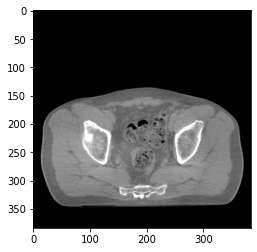

In [29]:
plt.imshow(x.squeeze(), 'gray'),

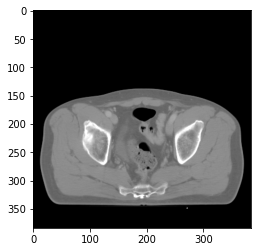

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer,
                                                                                             edge_discriminator, edge_dis_optimizer,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:41,  2.04it/s]
84it [01:26,  1.03s/it]
84it [00:28,  2.90it/s]
12it [00:04,  2.62it/s]
84it [00:38,  2.15it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.92it/s]
12it [00:04,  2.62it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.90it/s]
12it [00:04,  2.62it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.90it/s]
12it [00:04,  2.61it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.90it/s]
12it [00:04,  2.61it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.90it/s]
12it [00:04,  2.62it/s]
84it [00:39,  2.15it/s]
84it [01:27,  1.04s/it]
84it [00:29,  2.89it/s]
12it [00:04,  2.64it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.91it/s]
12it [00:04,  2.60it/s]
84it [00:39,  2.13it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.91it/s]
12it [00:04,  2.58it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.04s/it]
84it [00:28,  2.91it/s]
12it [00:04,  2.60it/s]
84it [00:39,  2.14it/s]
84it [01:27,  1.

KeyboardInterrupt: 

In [39]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [40]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [41]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8684906959533691
psnr score = 25.150981903076172
snr score = 15.213918685913086
mae error = 0.02278677187860012
air dice score = 0.9766208308109423
bone dice score = 0.9348500517072706
contour dice score = 0.5026674866676331


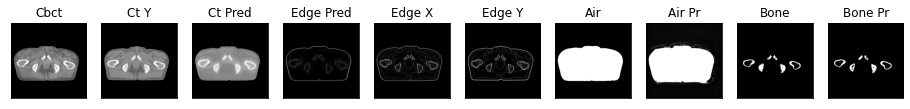

1it [00:00,  2.09it/s]

ssim score = 0.8682989478111267
psnr score = 25.16289520263672
snr score = 15.273368835449219
mae error = 0.022757286205887794
air dice score = 0.9771007031160169
bone dice score = 0.9299381807487498
contour dice score = 0.5349940657615662


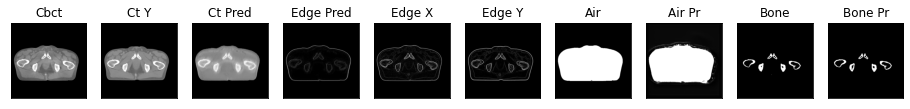

2it [00:00,  2.24it/s]

ssim score = 0.8699404001235962
psnr score = 25.197315216064453
snr score = 15.470684051513672
mae error = 0.022520342841744423
air dice score = 0.9776666826900181
bone dice score = 0.8981209254774624
contour dice score = 0.4763033092021942


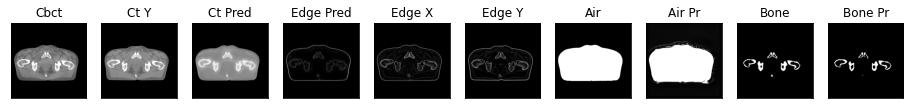

3it [00:01,  2.37it/s]

ssim score = 0.8678392171859741
psnr score = 25.273090362548828
snr score = 15.635711669921875
mae error = 0.022220496088266373
air dice score = 0.9788835701050235
bone dice score = 0.8689982216968701
contour dice score = 0.5080500841140747


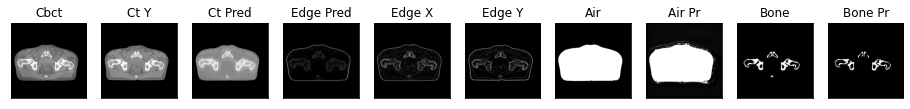

4it [00:01,  2.47it/s]

ssim score = 0.8680588006973267
psnr score = 25.477941513061523
snr score = 15.880867004394531
mae error = 0.02181931957602501
air dice score = 0.9794047238294814
bone dice score = 0.8337200309376452
contour dice score = 0.4752238690853119


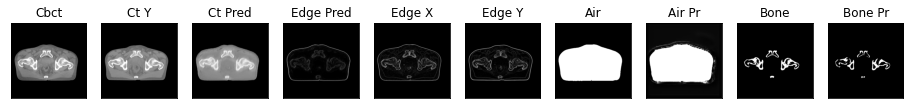

5it [00:01,  2.53it/s]

ssim score = 0.8682000041007996
psnr score = 25.35039520263672
snr score = 15.889853477478027
mae error = 0.022427314892411232
air dice score = 0.9786373404121053
bone dice score = 0.7730925687094642
contour dice score = 0.5065711140632629


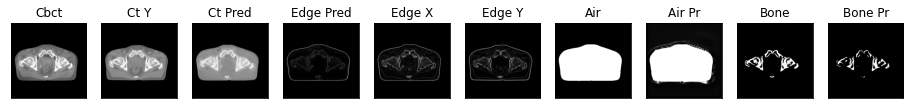

6it [00:02,  2.58it/s]

ssim score = 0.8642468452453613
psnr score = 24.999845504760742
snr score = 15.515246391296387
mae error = 0.023414328694343567
air dice score = 0.9765911110677299
bone dice score = 0.7580551803997871
contour dice score = 0.46875


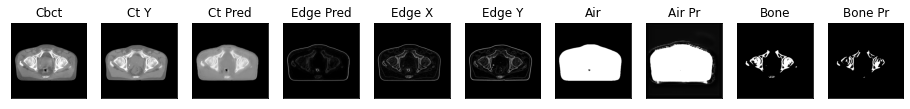

7it [00:02,  2.62it/s]

ssim score = 0.8664062023162842
psnr score = 25.429492950439453
snr score = 15.759357452392578
mae error = 0.022556010633707047
air dice score = 0.9750708270839092
bone dice score = 0.8266773162956602
contour dice score = 0.4295141100883484


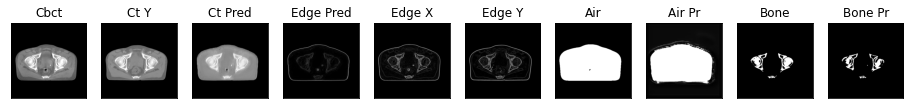

8it [00:03,  2.65it/s]

ssim score = 0.8723708391189575
psnr score = 25.669212341308594
snr score = 15.904522895812988
mae error = 0.022084994241595268
air dice score = 0.973884785819819
bone dice score = 0.8874445476128398
contour dice score = 0.43071386218070984


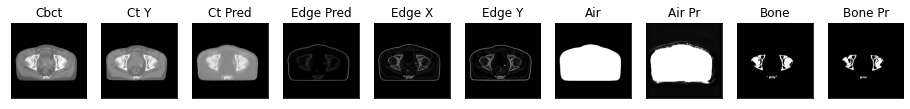

9it [00:03,  2.27it/s]

ssim score = 0.8771287798881531
psnr score = 25.735807418823242
snr score = 15.95583438873291
mae error = 0.02173498459160328
air dice score = 0.9717664975623542
bone dice score = 0.8868855977689752
contour dice score = 0.45525527000427246


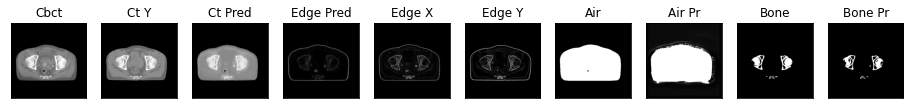

10it [00:04,  2.40it/s]

ssim score = 0.883614182472229
psnr score = 25.855918884277344
snr score = 16.10821533203125
mae error = 0.021558567881584167
air dice score = 0.9693999047468156
bone dice score = 0.928610835265049
contour dice score = 0.42737093567848206


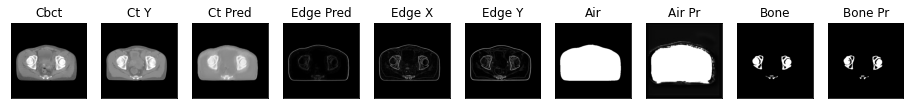

11it [00:04,  2.49it/s]

ssim score = 0.8863239288330078
psnr score = 25.032432556152344
snr score = 15.308438301086426
mae error = 0.022549349814653397
air dice score = 0.9670923575804005
bone dice score = 0.9071839404544131
contour dice score = 0.44885680079460144


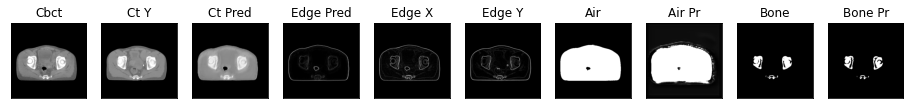

12it [00:04,  2.56it/s]

ssim score = 0.889401376247406
psnr score = 24.390228271484375
snr score = 14.634312629699707
mae error = 0.023199167102575302
air dice score = 0.9643653685071356
bone dice score = 0.9431871758611128
contour dice score = 0.4680604040622711


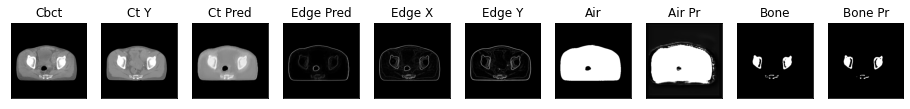

13it [00:05,  2.61it/s]

ssim score = 0.8846814632415771
psnr score = 24.492666244506836
snr score = 14.594793319702148
mae error = 0.022221926599740982
air dice score = 0.9609604737472257
bone dice score = 0.9181982914843619
contour dice score = 0.45707789063453674


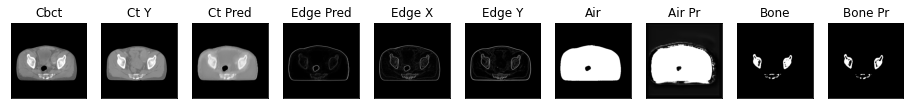

14it [00:05,  2.66it/s]

ssim score = 0.8821508288383484
psnr score = 24.50923728942871
snr score = 14.525703430175781
mae error = 0.0220522228628397
air dice score = 0.9603229621172366
bone dice score = 0.8968858131502161
contour dice score = 0.38548484444618225


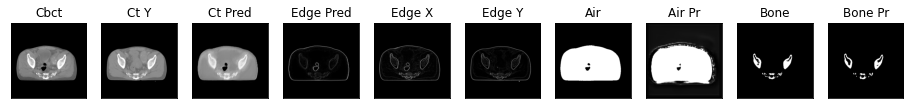

15it [00:05,  2.68it/s]

ssim score = 0.8785008788108826
psnr score = 24.37544059753418
snr score = 14.415392875671387
mae error = 0.022295324131846428
air dice score = 0.9562286122887214
bone dice score = 0.8999867180249703
contour dice score = 0.3469761908054352


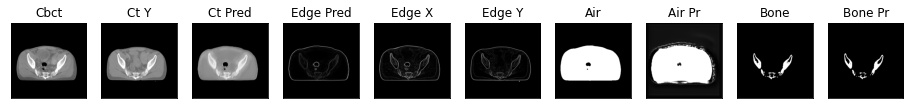

16it [00:06,  2.70it/s]

ssim score = 0.8736336827278137
psnr score = 23.624324798583984
snr score = 13.66173267364502
mae error = 0.023688586428761482
air dice score = 0.9508159657993682
bone dice score = 0.8822848321126684
contour dice score = 0.3116564452648163


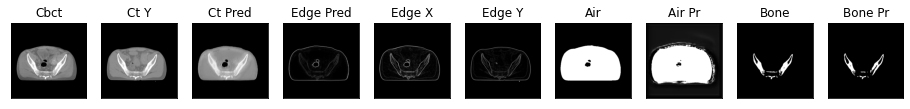

17it [00:06,  2.71it/s]

ssim score = 0.8656463623046875
psnr score = 23.184974670410156
snr score = 13.120620727539062
mae error = 0.024469465017318726
air dice score = 0.9451205036899983
bone dice score = 0.8639518135411294
contour dice score = 0.29936671257019043


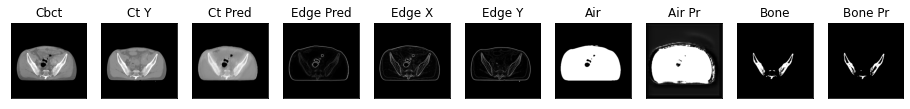

18it [00:06,  2.71it/s]

ssim score = 0.8635066747665405
psnr score = 23.097244262695312
snr score = 12.982207298278809
mae error = 0.0244402214884758
air dice score = 0.9380384873343259
bone dice score = 0.8534717715787998
contour dice score = 0.26035502552986145


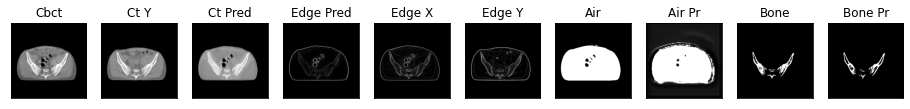

19it [00:07,  2.33it/s]

ssim score = 0.8643416166305542
psnr score = 23.112821578979492
snr score = 12.985477447509766
mae error = 0.0242924764752388
air dice score = 0.9365546392607678
bone dice score = 0.8548777210446805
contour dice score = 0.2602985203266144


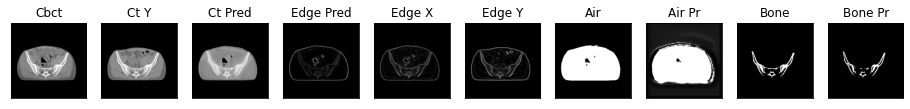

20it [00:07,  2.43it/s]

ssim score = 0.8605284690856934
psnr score = 22.971994400024414
snr score = 12.779804229736328
mae error = 0.024431303143501282
air dice score = 0.9310918083205902
bone dice score = 0.8622565864853629
contour dice score = 0.24308063089847565


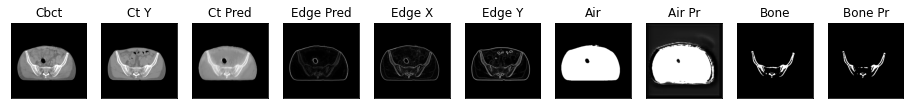

21it [00:08,  2.51it/s]

ssim score = 0.8559489250183105
psnr score = 23.088577270507812
snr score = 12.836953163146973
mae error = 0.023995043709874153
air dice score = 0.9253278151549644
bone dice score = 0.8692718583094001
contour dice score = 0.19736842811107635


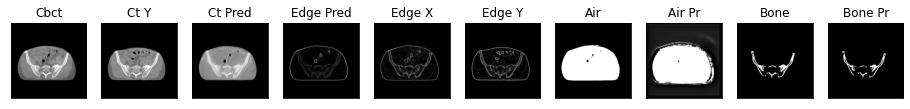

22it [00:08,  2.58it/s]

ssim score = 0.8575428128242493
psnr score = 23.154415130615234
snr score = 12.869366645812988
mae error = 0.023754609748721123
air dice score = 0.9197701149426125
bone dice score = 0.8738917559894946
contour dice score = 0.22605592012405396


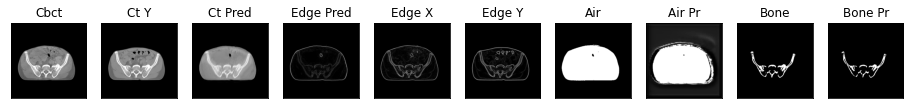

23it [00:08,  2.63it/s]

ssim score = 0.858967125415802
psnr score = 23.07732582092285
snr score = 12.743711471557617
mae error = 0.023825490847229958
air dice score = 0.9166614107012334
bone dice score = 0.851069345432909
contour dice score = 0.2199881672859192


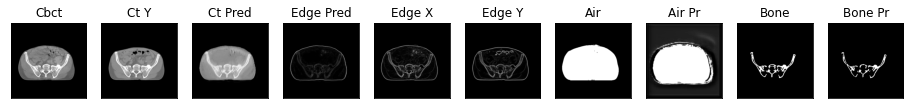

24it [00:09,  2.67it/s]

ssim score = 0.8539623022079468
psnr score = 22.961702346801758
snr score = 12.531088829040527
mae error = 0.024304816499352455
air dice score = 0.9073999873469417
bone dice score = 0.8286620164891736
contour dice score = 0.1944444477558136


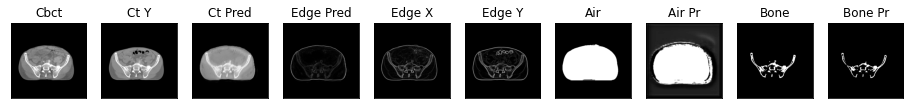

25it [00:09,  2.68it/s]

ssim score = 0.8485987186431885
psnr score = 22.974895477294922
snr score = 12.461548805236816
mae error = 0.02478916570544243
air dice score = 0.8964818979207958
bone dice score = 0.8217607338537168
contour dice score = 0.1795002520084381


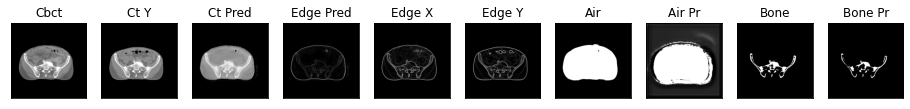

26it [00:10,  2.71it/s]

ssim score = 0.847025990486145
psnr score = 23.009693145751953
snr score = 12.405158996582031
mae error = 0.025167381390929222
air dice score = 0.887189374926067
bone dice score = 0.8047232097536221
contour dice score = 0.18965516984462738


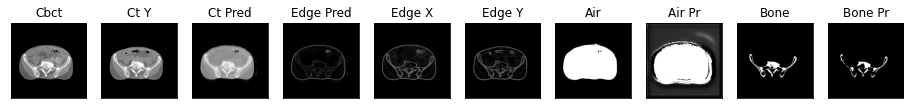

27it [00:10,  2.72it/s]

ssim score = 0.8429427146911621
psnr score = 22.90519905090332
snr score = 12.25955867767334
mae error = 0.02557266689836979
air dice score = 0.8818045504923379
bone dice score = 0.8069666182897076
contour dice score = 0.12007062882184982


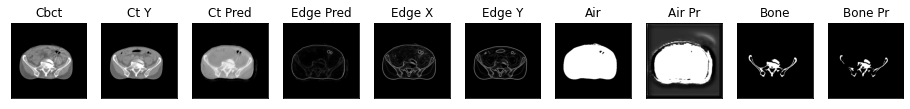

28it [00:10,  2.73it/s]

ssim score = 0.8345333337783813
psnr score = 22.062902450561523
snr score = 13.435059547424316
mae error = 0.040050018578767776
air dice score = 0.9965844965844987
bone dice score = 0.947948560932396
contour dice score = 0.369047611951828


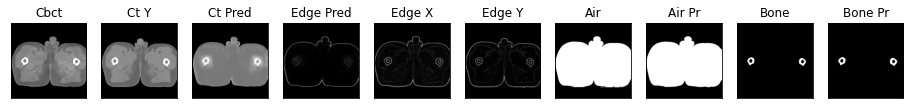

29it [00:11,  2.33it/s]

ssim score = 0.8382524847984314
psnr score = 22.49302101135254
snr score = 13.904438018798828
mae error = 0.03915024548768997
air dice score = 0.9955919588501109
bone dice score = 0.9520785219413372
contour dice score = 0.33108678460121155


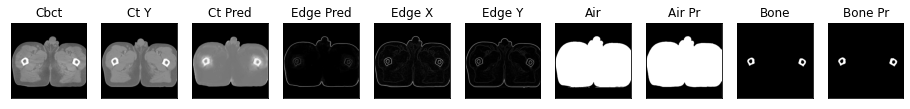

30it [00:11,  2.44it/s]

ssim score = 0.8443830609321594
psnr score = 22.939571380615234
snr score = 14.438436508178711
mae error = 0.03863852098584175
air dice score = 0.9953706523725435
bone dice score = 0.95752539242942
contour dice score = 0.29419583082199097


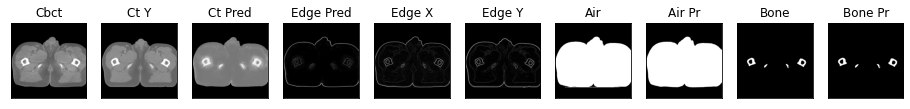

31it [00:12,  2.52it/s]

ssim score = 0.8444350957870483
psnr score = 23.214736938476562
snr score = 14.876155853271484
mae error = 0.03914180025458336
air dice score = 0.9963416554614745
bone dice score = 0.95488477767032
contour dice score = 0.24839596450328827


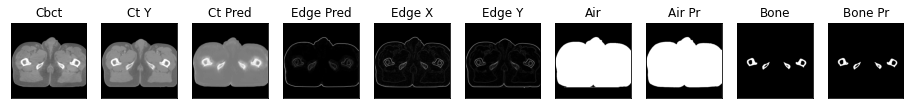

32it [00:12,  2.59it/s]

ssim score = 0.8406150341033936
psnr score = 23.189796447753906
snr score = 14.979361534118652
mae error = 0.039810873568058014
air dice score = 0.9961392290523037
bone dice score = 0.9410592255133676
contour dice score = 0.20213259756565094


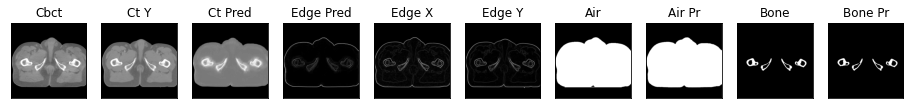

33it [00:12,  2.63it/s]

ssim score = 0.8395397067070007
psnr score = 23.28980255126953
snr score = 15.18260383605957
mae error = 0.03988506644964218
air dice score = 0.9965515169720658
bone dice score = 0.9194120628494753
contour dice score = 0.22284123301506042


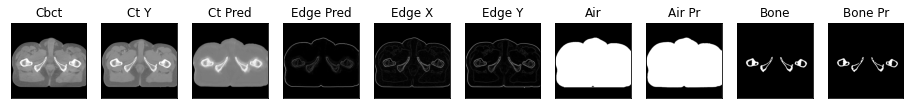

34it [00:13,  2.67it/s]

ssim score = 0.8407440185546875
psnr score = 23.41374397277832
snr score = 15.373648643493652
mae error = 0.03954022377729416
air dice score = 0.9959478305630565
bone dice score = 0.9014784151401362
contour dice score = 0.26555246114730835


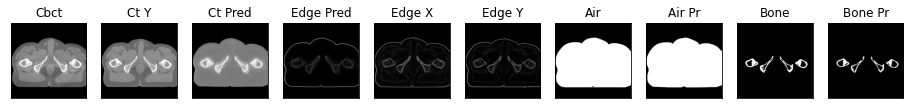

35it [00:13,  2.69it/s]

ssim score = 0.8408774137496948
psnr score = 23.637779235839844
snr score = 15.587791442871094
mae error = 0.038682807236909866
air dice score = 0.9963430712236118
bone dice score = 0.9075346322794511
contour dice score = 0.2945808172225952


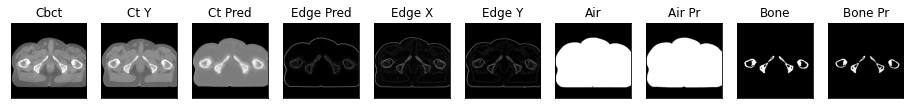

36it [00:13,  2.70it/s]

ssim score = 0.8422470688819885
psnr score = 23.731552124023438
snr score = 15.667901992797852
mae error = 0.03829726576805115
air dice score = 0.9959804441162659
bone dice score = 0.8938433680410384
contour dice score = 0.2925925850868225


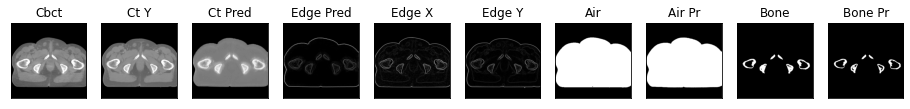

37it [00:14,  2.71it/s]

ssim score = 0.84779292345047
psnr score = 23.847444534301758
snr score = 15.795794486999512
mae error = 0.03834883123636246
air dice score = 0.9960574435821984
bone dice score = 0.8894762133602897
contour dice score = 0.2993512451648712


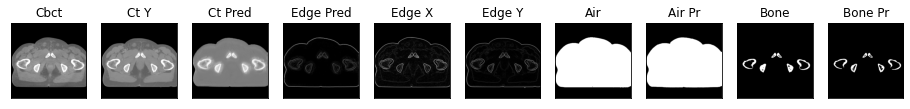

38it [00:14,  2.70it/s]

ssim score = 0.8496766686439514
psnr score = 23.820110321044922
snr score = 15.80754280090332
mae error = 0.03843305632472038
air dice score = 0.9960878974529739
bone dice score = 0.9005491153154295
contour dice score = 0.28850626945495605


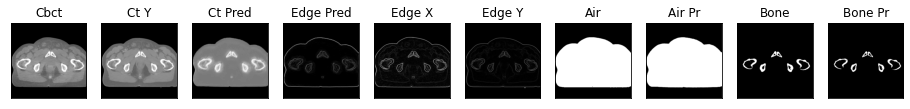

39it [00:15,  2.32it/s]

ssim score = 0.848286509513855
psnr score = 23.580209732055664
snr score = 15.70893383026123
mae error = 0.03975186124444008
air dice score = 0.995606342562593
bone dice score = 0.8836913959161425
contour dice score = 0.3110696077346802


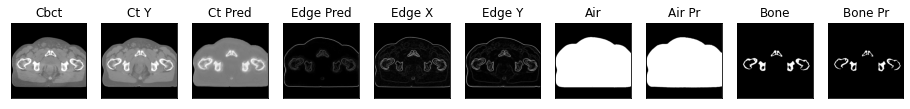

40it [00:15,  2.43it/s]

ssim score = 0.8432708382606506
psnr score = 23.38546371459961
snr score = 15.608872413635254
mae error = 0.04063252732157707
air dice score = 0.995719244348393
bone dice score = 0.8407689517606024
contour dice score = 0.2849135994911194


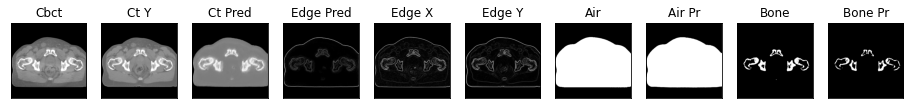

41it [00:15,  2.51it/s]

ssim score = 0.8330602645874023
psnr score = 23.114002227783203
snr score = 15.303365707397461
mae error = 0.04062189906835556
air dice score = 0.9953360604341492
bone dice score = 0.7946656923657777
contour dice score = 0.3122362792491913


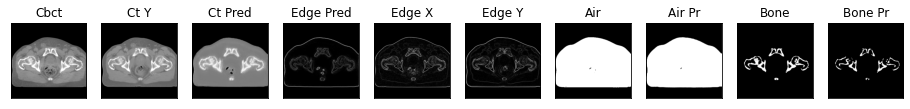

42it [00:16,  2.57it/s]

ssim score = 0.8240250945091248
psnr score = 22.25589942932129
snr score = 14.517448425292969
mae error = 0.04275475814938545
air dice score = 0.9943479724854525
bone dice score = 0.7251845775248139
contour dice score = 0.2793979346752167


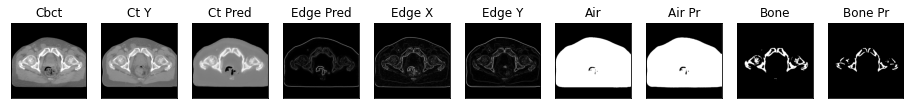

43it [00:16,  2.62it/s]

ssim score = 0.8296589255332947
psnr score = 22.664409637451172
snr score = 14.789863586425781
mae error = 0.04160622879862785
air dice score = 0.9957333461895432
bone dice score = 0.7899598393595385
contour dice score = 0.32468146085739136


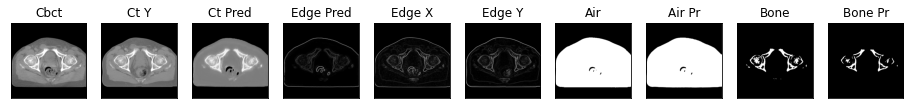

44it [00:17,  2.66it/s]

ssim score = 0.8369014859199524
psnr score = 23.0112361907959
snr score = 14.958131790161133
mae error = 0.04001917317509651
air dice score = 0.9959276400855582
bone dice score = 0.8303967138706042
contour dice score = 0.3587316572666168


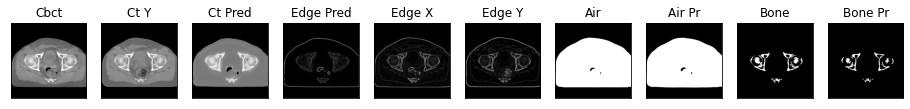

45it [00:17,  2.68it/s]

ssim score = 0.8418652415275574
psnr score = 23.534122467041016
snr score = 15.390424728393555
mae error = 0.03861172869801521
air dice score = 0.9961348390726057
bone dice score = 0.8516236074916849
contour dice score = 0.4019002318382263


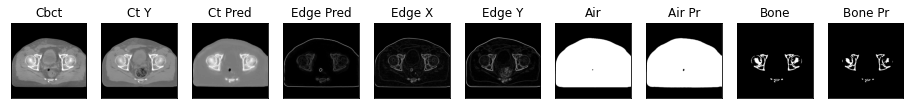

46it [00:17,  2.70it/s]

ssim score = 0.8451671600341797
psnr score = 23.542823791503906
snr score = 15.41481876373291
mae error = 0.0388697125017643
air dice score = 0.9968285599718113
bone dice score = 0.8542860352785722
contour dice score = 0.3956252932548523


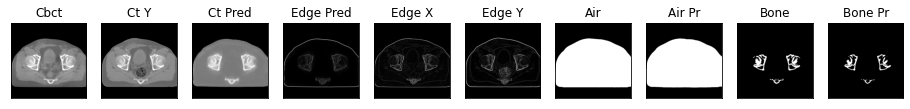

47it [00:18,  2.71it/s]

ssim score = 0.8380379676818848
psnr score = 23.40899658203125
snr score = 15.291028022766113
mae error = 0.039232246577739716
air dice score = 0.9966054508156708
bone dice score = 0.8441611842121283
contour dice score = 0.41372737288475037


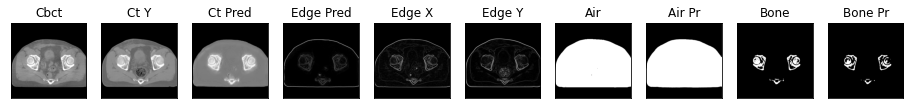

48it [00:18,  2.71it/s]

ssim score = 0.8426211476325989
psnr score = 23.500585556030273
snr score = 15.444206237792969
mae error = 0.038874659687280655
air dice score = 0.996495570450064
bone dice score = 0.8560885608870441
contour dice score = 0.39084842801094055


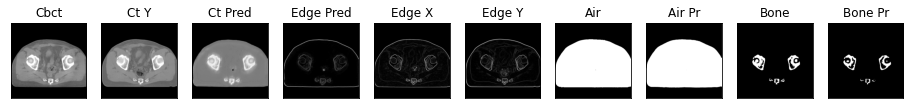

49it [00:19,  2.32it/s]

ssim score = 0.8429747819900513
psnr score = 23.45159339904785
snr score = 15.465295791625977
mae error = 0.03970247507095337
air dice score = 0.9961069424146806
bone dice score = 0.8925996204943776
contour dice score = 0.3960019052028656


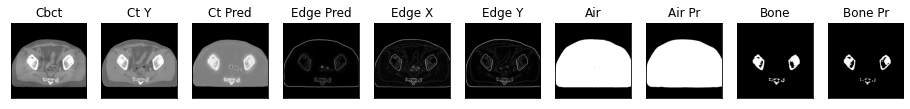

50it [00:19,  2.43it/s]

ssim score = 0.8432131409645081
psnr score = 23.49590301513672
snr score = 15.39050006866455
mae error = 0.03896263241767883
air dice score = 0.9964868317610085
bone dice score = 0.8846681439286201
contour dice score = 0.3755958080291748


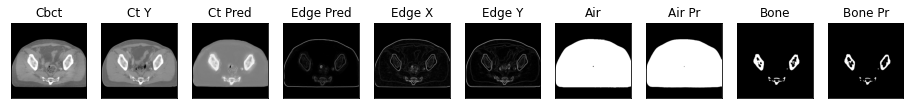

51it [00:19,  2.51it/s]

ssim score = 0.8398406505584717
psnr score = 23.073192596435547
snr score = 15.04941463470459
mae error = 0.04009925574064255
air dice score = 0.9959927587370772
bone dice score = 0.8708775852443555
contour dice score = 0.33891814947128296


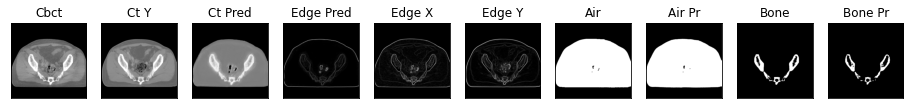

52it [00:20,  2.58it/s]

ssim score = 0.8328831791877747
psnr score = 23.030948638916016
snr score = 15.087319374084473
mae error = 0.040200479328632355
air dice score = 0.9954088231508128
bone dice score = 0.8150875470478229
contour dice score = 0.26295584440231323


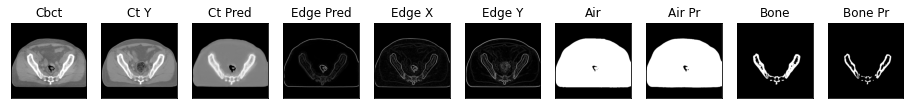

53it [00:20,  2.62it/s]

ssim score = 0.824801504611969
psnr score = 22.80649185180664
snr score = 14.884419441223145
mae error = 0.04039997607469559
air dice score = 0.9950239023853511
bone dice score = 0.7967384973808409
contour dice score = 0.3184223175048828


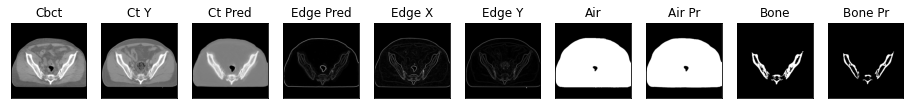

54it [00:20,  2.66it/s]

ssim score = 0.8336166739463806
psnr score = 23.29515266418457
snr score = 15.385618209838867
mae error = 0.03910157456994057
air dice score = 0.9950716221213272
bone dice score = 0.8075408462521363
contour dice score = 0.3259827494621277


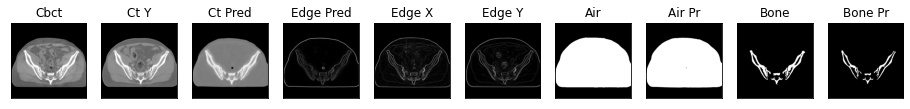

55it [00:21,  2.68it/s]

ssim score = 0.8176971673965454
psnr score = 20.927227020263672
snr score = 10.807433128356934
mae error = 0.034864846616983414
air dice score = 0.989403353100788
bone dice score = 0.918041106320273
contour dice score = 0.5945054888725281


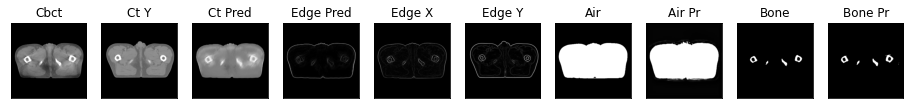

56it [00:21,  2.71it/s]

ssim score = 0.8070873618125916
psnr score = 20.738441467285156
snr score = 10.831632614135742
mae error = 0.03652133420109749
air dice score = 0.9905262880114084
bone dice score = 0.9060104881019361
contour dice score = 0.6194398403167725


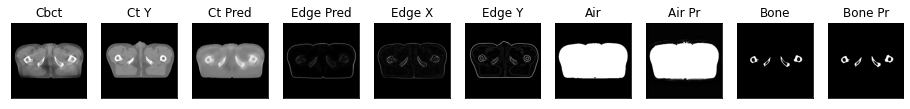

57it [00:22,  2.72it/s]

ssim score = 0.7999467253684998
psnr score = 20.72129249572754
snr score = 10.9456205368042
mae error = 0.03739538788795471
air dice score = 0.9910278966763907
bone dice score = 0.8869598037386873
contour dice score = 0.5873972773551941


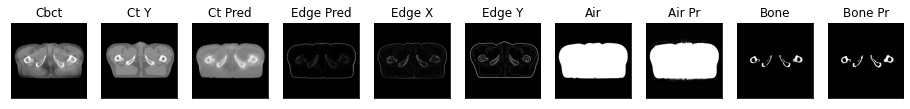

58it [00:22,  2.73it/s]

ssim score = 0.8020685315132141
psnr score = 21.043766021728516
snr score = 11.338495254516602
mae error = 0.036218930035829544
air dice score = 0.9922344143563173
bone dice score = 0.8857247170521043
contour dice score = 0.6324412822723389


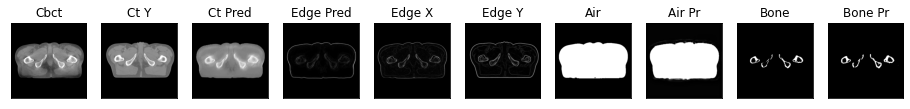

59it [00:22,  2.33it/s]

ssim score = 0.8028134703636169
psnr score = 21.111652374267578
snr score = 11.453948974609375
mae error = 0.036044348031282425
air dice score = 0.9917110048345311
bone dice score = 0.8890882986380279
contour dice score = 0.5925925970077515


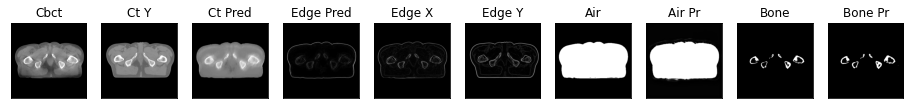

60it [00:23,  2.45it/s]

ssim score = 0.802074134349823
psnr score = 21.230815887451172
snr score = 11.578727722167969
mae error = 0.03560757637023926
air dice score = 0.9916760404949453
bone dice score = 0.9046446164689542
contour dice score = 0.5856236815452576


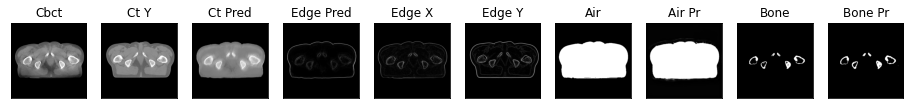

61it [00:23,  2.53it/s]

ssim score = 0.8038638234138489
psnr score = 21.27602767944336
snr score = 11.617437362670898
mae error = 0.03527400642633438
air dice score = 0.9921401147491548
bone dice score = 0.9120839363257582
contour dice score = 0.6050955653190613


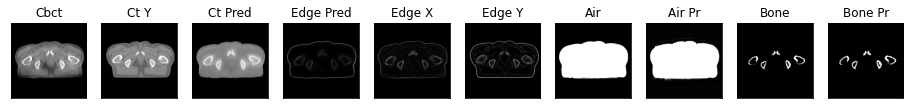

62it [00:24,  2.58it/s]

ssim score = 0.8038604259490967
psnr score = 21.146934509277344
snr score = 11.50245189666748
mae error = 0.03546649217605591
air dice score = 0.992515871513865
bone dice score = 0.9079063215371033
contour dice score = 0.586426317691803


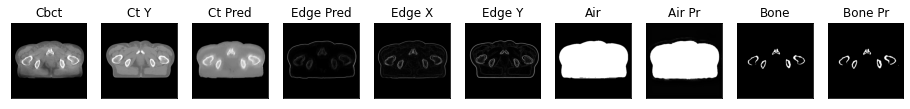

63it [00:24,  2.63it/s]

ssim score = 0.8031231164932251
psnr score = 21.024147033691406
snr score = 11.43767261505127
mae error = 0.036096520721912384
air dice score = 0.9921723963121829
bone dice score = 0.8958068615010196
contour dice score = 0.5450666546821594


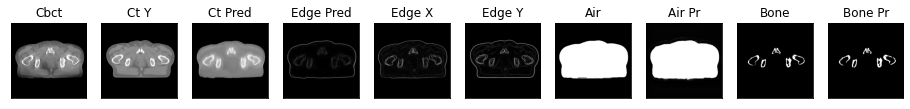

64it [00:24,  2.67it/s]

ssim score = 0.79445481300354
psnr score = 20.81538963317871
snr score = 11.327475547790527
mae error = 0.03749757632613182
air dice score = 0.992481074083289
bone dice score = 0.876927822333792
contour dice score = 0.542283296585083


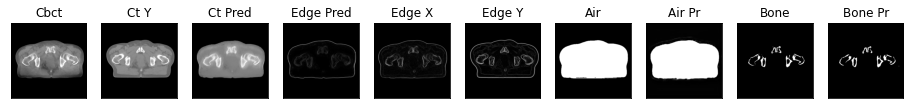

65it [00:25,  2.69it/s]

ssim score = 0.7854305505752563
psnr score = 20.798852920532227
snr score = 11.346765518188477
mae error = 0.037903930991888046
air dice score = 0.9928311421352466
bone dice score = 0.8689696247786037
contour dice score = 0.4983888268470764


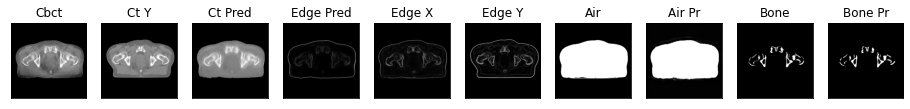

66it [00:25,  2.72it/s]

ssim score = 0.7771799564361572
psnr score = 20.75728416442871
snr score = 11.33790397644043
mae error = 0.03769301995635033
air dice score = 0.9929816152555779
bone dice score = 0.8235624123446905
contour dice score = 0.488770067691803


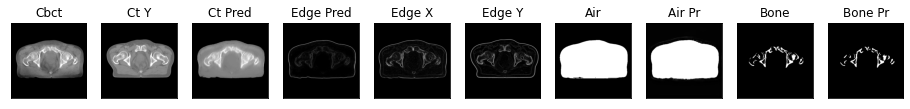

67it [00:25,  2.72it/s]

ssim score = 0.7780709266662598
psnr score = 20.716951370239258
snr score = 11.414389610290527
mae error = 0.03796180710196495
air dice score = 0.9930922319709026
bone dice score = 0.8583464981587895
contour dice score = 0.5123879909515381


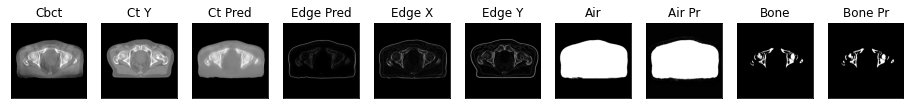

68it [00:26,  2.73it/s]

ssim score = 0.7818658351898193
psnr score = 20.46120834350586
snr score = 11.142660140991211
mae error = 0.03894807770848274
air dice score = 0.9923429274629176
bone dice score = 0.861196105704295
contour dice score = 0.5560391545295715


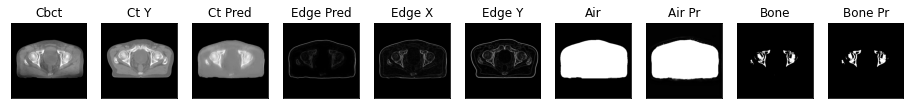

69it [00:26,  2.33it/s]

ssim score = 0.7967625856399536
psnr score = 20.947845458984375
snr score = 11.430134773254395
mae error = 0.03612222522497177
air dice score = 0.9916825196420569
bone dice score = 0.8791965566731823
contour dice score = 0.5560923218727112


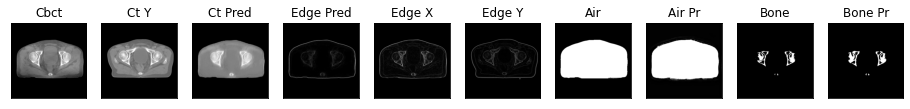

70it [00:27,  2.44it/s]

ssim score = 0.8128311634063721
psnr score = 21.641645431518555
snr score = 11.953540802001953
mae error = 0.03278860077261925
air dice score = 0.9916206826078142
bone dice score = 0.8966261808381022
contour dice score = 0.573576807975769


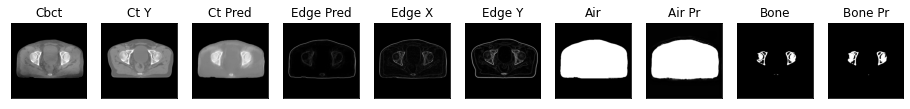

71it [00:27,  2.53it/s]

ssim score = 0.8197363018989563
psnr score = 22.06121063232422
snr score = 12.387273788452148
mae error = 0.031335461884737015
air dice score = 0.9921176820713472
bone dice score = 0.9198192382192405
contour dice score = 0.5610666871070862


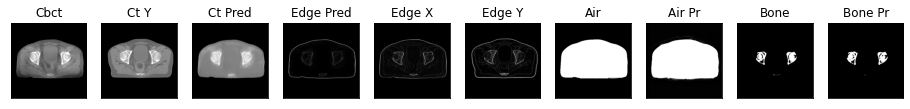

72it [00:27,  2.59it/s]

ssim score = 0.8237127661705017
psnr score = 22.34125328063965
snr score = 12.749146461486816
mae error = 0.031060868874192238
air dice score = 0.9922589845009997
bone dice score = 0.9460758142025351
contour dice score = 0.5200433135032654


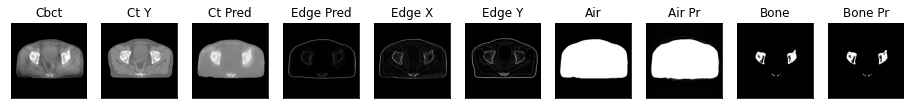

73it [00:28,  2.64it/s]

ssim score = 0.8252651691436768
psnr score = 22.370817184448242
snr score = 12.87088394165039
mae error = 0.031612347811460495
air dice score = 0.9927006063069533
bone dice score = 0.9206487112667152
contour dice score = 0.5274725556373596


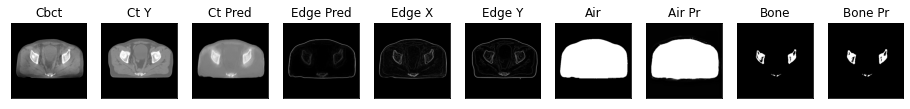

74it [00:28,  2.66it/s]

ssim score = 0.822097897529602
psnr score = 22.559144973754883
snr score = 12.995781898498535
mae error = 0.03151886910200119
air dice score = 0.9926090918295091
bone dice score = 0.9348866900744512
contour dice score = 0.5438972115516663


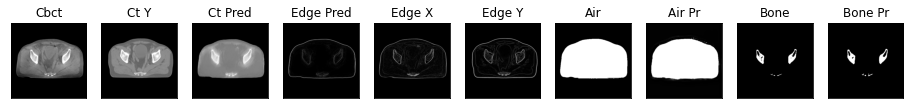

75it [00:28,  2.66it/s]

ssim score = 0.8219307661056519
psnr score = 22.66546630859375
snr score = 13.06571102142334
mae error = 0.031197452917695045
air dice score = 0.9923953731494348
bone dice score = 0.9310523587362873
contour dice score = 0.5702127814292908


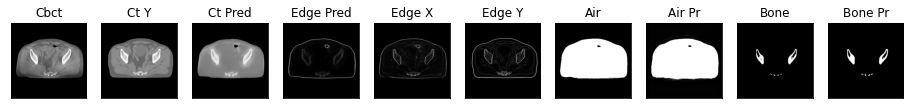

76it [00:29,  2.69it/s]

ssim score = 0.8174200654029846
psnr score = 22.650468826293945
snr score = 13.088459968566895
mae error = 0.03158288076519966
air dice score = 0.991991637583673
bone dice score = 0.9135842880537874
contour dice score = 0.5503711700439453


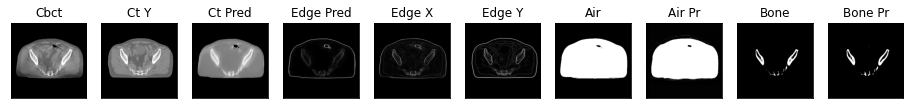

77it [00:29,  2.71it/s]

ssim score = 0.8088703751564026
psnr score = 22.637807846069336
snr score = 13.206302642822266
mae error = 0.031928207725286484
air dice score = 0.991900647948171
bone dice score = 0.9203826342910908
contour dice score = 0.5520555377006531


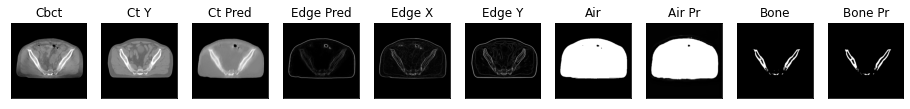

78it [00:30,  2.72it/s]

ssim score = 0.8107908368110657
psnr score = 22.585317611694336
snr score = 13.171563148498535
mae error = 0.032056599855422974
air dice score = 0.9912579867135013
bone dice score = 0.8954381564524935
contour dice score = 0.5702036619186401


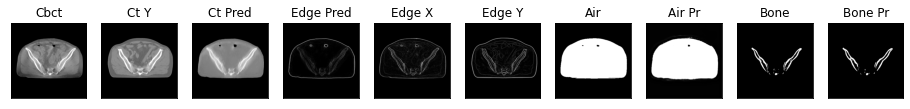

79it [00:30,  2.34it/s]

ssim score = 0.8128159046173096
psnr score = 22.953067779541016
snr score = 13.52804183959961
mae error = 0.031169235706329346
air dice score = 0.9903896765430085
bone dice score = 0.8870623047856804
contour dice score = 0.5678879022598267


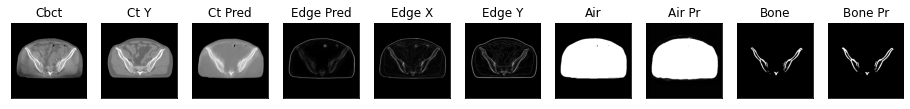

80it [00:31,  2.44it/s]

ssim score = 0.8156484961509705
psnr score = 23.219881057739258
snr score = 13.79411506652832
mae error = 0.03013404831290245
air dice score = 0.9903778135733422
bone dice score = 0.867581365668992
contour dice score = 0.5105690956115723


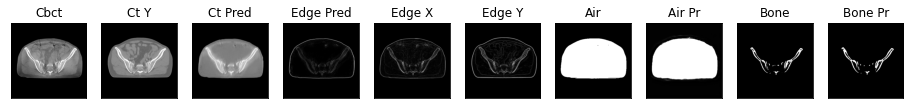

81it [00:31,  2.53it/s]

ssim score = 0.838184118270874
psnr score = 22.775724411010742
snr score = 13.209857940673828
mae error = 0.03167818859219551
air dice score = 0.9947853101076265
bone dice score = 0.8740130449751454
contour dice score = 0.6118769645690918


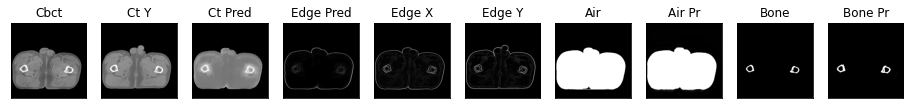

82it [00:31,  2.59it/s]

ssim score = 0.8372530341148376
psnr score = 22.956266403198242
snr score = 13.454794883728027
mae error = 0.0316886305809021
air dice score = 0.9959516721011956
bone dice score = 0.862527031205977
contour dice score = 0.6024096608161926


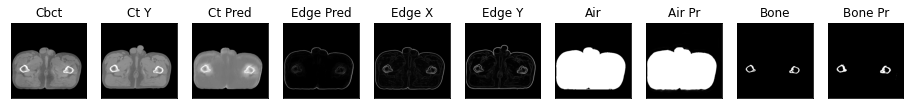

83it [00:32,  2.64it/s]

ssim score = 0.8439109921455383
psnr score = 24.130023956298828
snr score = 14.767763137817383
mae error = 0.029471242800354958
air dice score = 0.995770336269954
bone dice score = 0.9108494533239939
contour dice score = 0.6554877758026123


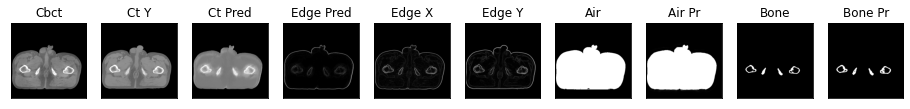

84it [00:32,  2.67it/s]

ssim score = 0.8436738848686218
psnr score = 24.066421508789062
snr score = 14.825653076171875
mae error = 0.03002167120575905
air dice score = 0.996209684295384
bone dice score = 0.8902053712501934
contour dice score = 0.6718027591705322


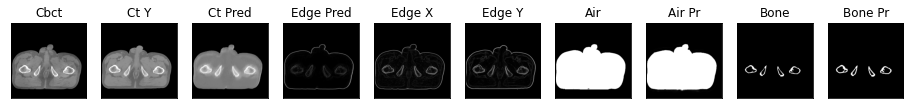

85it [00:32,  2.66it/s]

ssim score = 0.8400509357452393
psnr score = 23.952531814575195
snr score = 14.735933303833008
mae error = 0.030447933822870255
air dice score = 0.9966729081877435
bone dice score = 0.861979685324398
contour dice score = 0.671842634677887


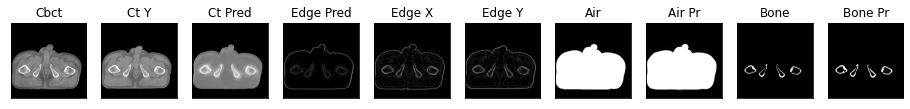

86it [00:33,  2.68it/s]

ssim score = 0.8387789130210876
psnr score = 23.775306701660156
snr score = 14.554311752319336
mae error = 0.030667802318930626
air dice score = 0.996691608434855
bone dice score = 0.8728813559345453
contour dice score = 0.6510171890258789


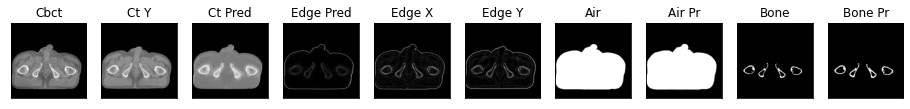

87it [00:33,  2.70it/s]

ssim score = 0.8395065069198608
psnr score = 23.55369758605957
snr score = 14.338958740234375
mae error = 0.03069313056766987
air dice score = 0.9968004698826863
bone dice score = 0.8866171003738547
contour dice score = 0.5822385549545288


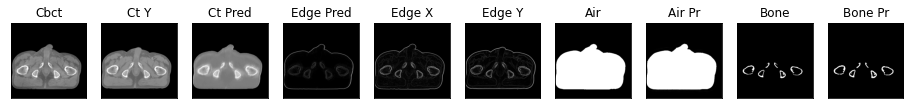

88it [00:33,  2.67it/s]

ssim score = 0.8363573551177979
psnr score = 23.351043701171875
snr score = 14.114750862121582
mae error = 0.030825432389974594
air dice score = 0.9968757250019358
bone dice score = 0.901260109085927
contour dice score = 0.6540284156799316


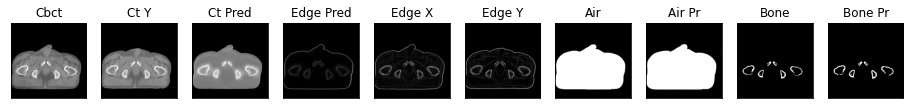

89it [00:34,  2.29it/s]

ssim score = 0.8380876779556274
psnr score = 23.461591720581055
snr score = 14.242206573486328
mae error = 0.030241383239626884
air dice score = 0.9967200911861199
bone dice score = 0.9119170984471696
contour dice score = 0.5975674390792847


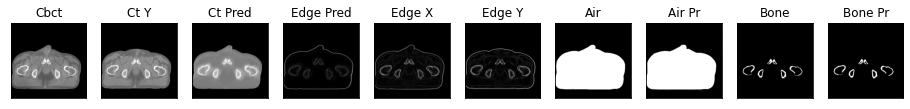

90it [00:34,  2.40it/s]

ssim score = 0.8401660919189453
psnr score = 23.803585052490234
snr score = 14.65279483795166
mae error = 0.029480375349521637
air dice score = 0.9969090385319125
bone dice score = 0.9045373231435268
contour dice score = 0.6574172973632812


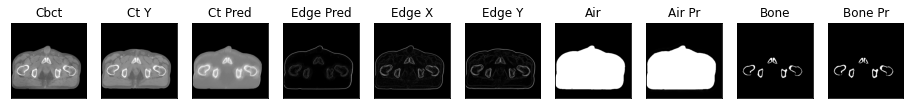

91it [00:35,  2.49it/s]

ssim score = 0.8411539196968079
psnr score = 24.18600082397461
snr score = 15.116567611694336
mae error = 0.028600143268704414
air dice score = 0.9967950722281308
bone dice score = 0.8960336538477158
contour dice score = 0.6237941980361938


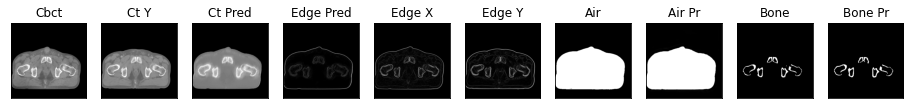

92it [00:35,  2.53it/s]

ssim score = 0.8448939919471741
psnr score = 24.517139434814453
snr score = 15.498411178588867
mae error = 0.027668097987771034
air dice score = 0.9964449676280193
bone dice score = 0.8602214022160853
contour dice score = 0.6774020195007324


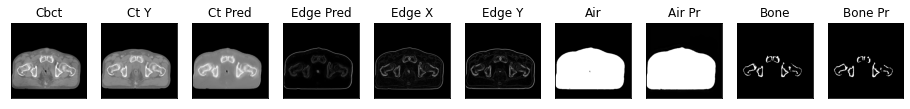

93it [00:36,  2.58it/s]

ssim score = 0.8486969470977783
psnr score = 24.813926696777344
snr score = 15.91146469116211
mae error = 0.026885515078902245
air dice score = 0.9970783490703503
bone dice score = 0.8346906700980898
contour dice score = 0.6526656150817871


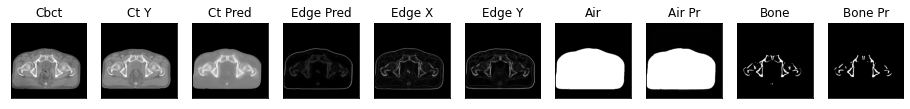

94it [00:36,  2.62it/s]

ssim score = 0.8441250920295715
psnr score = 24.357742309570312
snr score = 15.417049407958984
mae error = 0.02740602381527424
air dice score = 0.9965654231493672
bone dice score = 0.8113179449022886
contour dice score = 0.6594943404197693


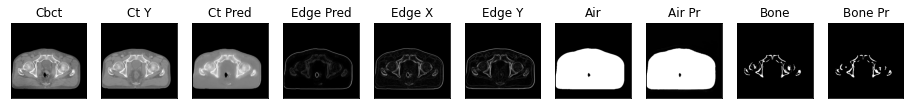

95it [00:36,  2.65it/s]

ssim score = 0.8381412625312805
psnr score = 23.745094299316406
snr score = 14.70872688293457
mae error = 0.02853059396147728
air dice score = 0.9953151143335229
bone dice score = 0.8072787427652705
contour dice score = 0.633567214012146


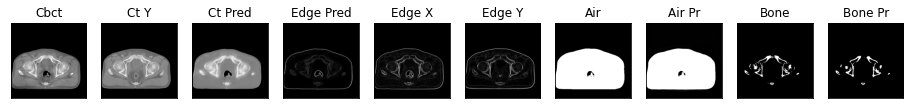

96it [00:37,  2.65it/s]

ssim score = 0.8406167030334473
psnr score = 23.4599666595459
snr score = 14.263840675354004
mae error = 0.03010004200041294
air dice score = 0.9948861814684234
bone dice score = 0.8484273747455598
contour dice score = 0.6385281682014465


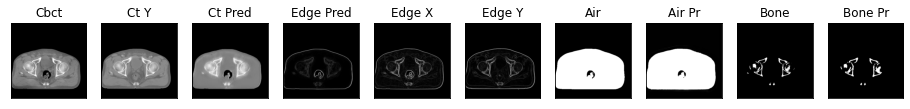

97it [00:37,  2.68it/s]

ssim score = 0.839844822883606
psnr score = 23.16016960144043
snr score = 13.847617149353027
mae error = 0.030796190723776817
air dice score = 0.9949287103046055
bone dice score = 0.857591458629964
contour dice score = 0.6767895817756653


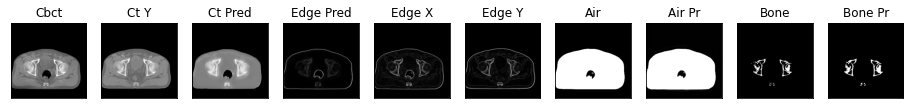

98it [00:37,  2.69it/s]

ssim score = 0.840320885181427
psnr score = 23.154199600219727
snr score = 13.796554565429688
mae error = 0.030205467715859413
air dice score = 0.9943520322089061
bone dice score = 0.8730300327107786
contour dice score = 0.6561307907104492


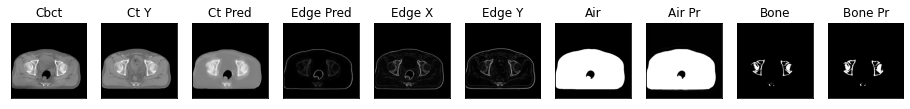

99it [00:38,  2.31it/s]

ssim score = 0.8380947709083557
psnr score = 22.89559555053711
snr score = 13.544625282287598
mae error = 0.030839188024401665
air dice score = 0.9943679905969975
bone dice score = 0.8986202759463314
contour dice score = 0.6594005227088928


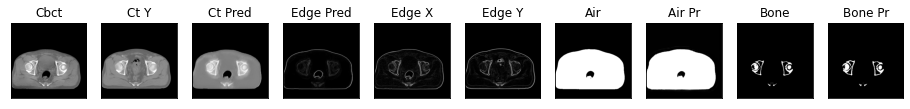

100it [00:38,  2.39it/s]

ssim score = 0.8425007462501526
psnr score = 22.637617111206055
snr score = 13.316749572753906
mae error = 0.031537000089883804
air dice score = 0.9943812413612654
bone dice score = 0.9231675007370743
contour dice score = 0.6273223757743835


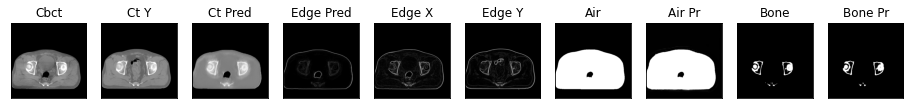

101it [00:39,  2.48it/s]

ssim score = 0.8492218852043152
psnr score = 23.327558517456055
snr score = 13.964104652404785
mae error = 0.029887057840824127
air dice score = 0.9941866161533736
bone dice score = 0.9247524752487665
contour dice score = 0.6433643102645874


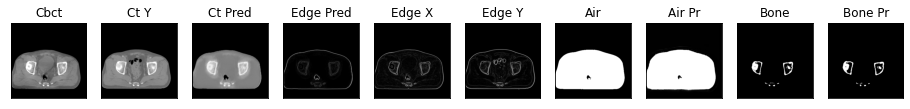

102it [00:39,  2.55it/s]

ssim score = 0.8492275476455688
psnr score = 23.65185546875
snr score = 14.19819450378418
mae error = 0.028654886409640312
air dice score = 0.9945227943588106
bone dice score = 0.9045568711893692
contour dice score = 0.6119321584701538


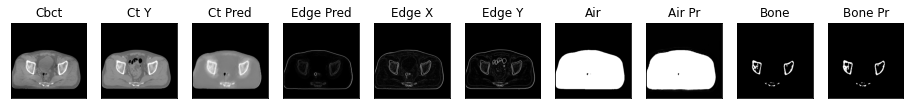

103it [00:39,  2.60it/s]

ssim score = 0.8499652147293091
psnr score = 23.311229705810547
snr score = 13.79184341430664
mae error = 0.029063697904348373
air dice score = 0.994028738250036
bone dice score = 0.925253297650062
contour dice score = 0.619178056716919


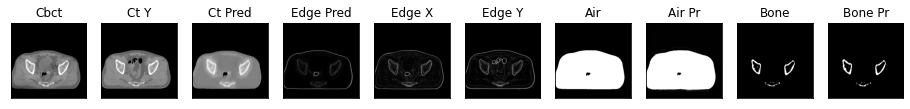

104it [00:40,  2.62it/s]

ssim score = 0.8476207852363586
psnr score = 23.332069396972656
snr score = 13.812381744384766
mae error = 0.028715845197439194
air dice score = 0.993279076748613
bone dice score = 0.9259322322505376
contour dice score = 0.6169862747192383


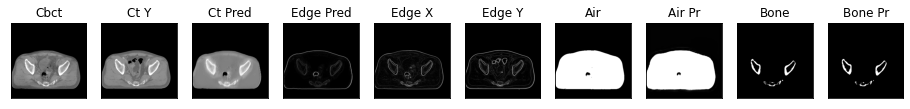

105it [00:40,  2.65it/s]

ssim score = 0.8424515128135681
psnr score = 23.264514923095703
snr score = 13.820995330810547
mae error = 0.02907402068376541
air dice score = 0.992820892633215
bone dice score = 0.9101934738678863
contour dice score = 0.5742574334144592


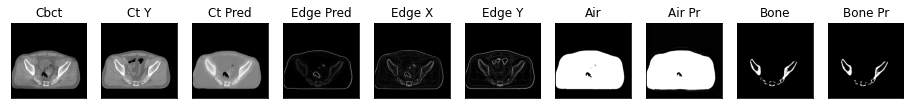

106it [00:41,  2.67it/s]

ssim score = 0.8464323878288269
psnr score = 23.556549072265625
snr score = 14.148612022399902
mae error = 0.02799750678241253
air dice score = 0.9925287161589871
bone dice score = 0.8990344827600133
contour dice score = 0.5473568439483643


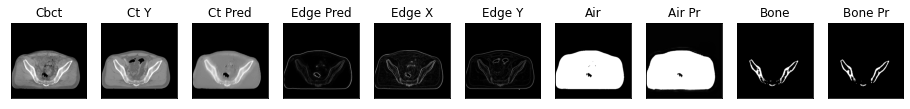

107it [00:41,  2.69it/s]

ssim score = 0.8473936915397644
psnr score = 24.049846649169922
snr score = 14.580209732055664
mae error = 0.026845134794712067
air dice score = 0.9924372753751619
bone dice score = 0.8807975726068372
contour dice score = 0.5246264338493347


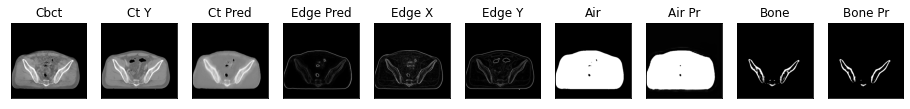

108it [00:41,  2.70it/s]

ssim score = 0.8465244770050049
psnr score = 23.827810287475586
snr score = 14.296913146972656
mae error = 0.027242643758654594
air dice score = 0.992103953173016
bone dice score = 0.8798455369095523
contour dice score = 0.5030812621116638


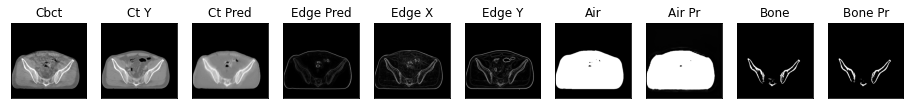

109it [00:42,  2.30it/s]

ssim score = 0.8073188066482544
psnr score = 21.589920043945312
snr score = 13.287227630615234
mae error = 0.044423338025808334
air dice score = 0.9967094926689888
bone dice score = 0.9227067669196178
contour dice score = 0.3013215959072113


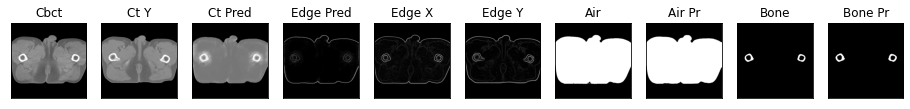

110it [00:42,  2.41it/s]

ssim score = 0.7950494289398193
psnr score = 21.156265258789062
snr score = 12.957862854003906
mae error = 0.04628731682896614
air dice score = 0.9966451856350288
bone dice score = 0.9242465381503056
contour dice score = 0.31288889050483704


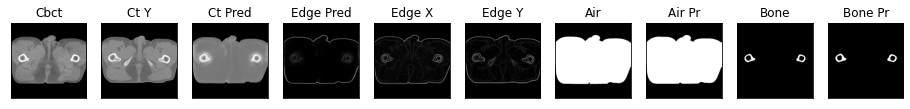

111it [00:43,  2.49it/s]

ssim score = 0.7909195423126221
psnr score = 20.971881866455078
snr score = 12.901434898376465
mae error = 0.0485394150018692
air dice score = 0.9963553852122715
bone dice score = 0.9142359599496248
contour dice score = 0.27894502878189087


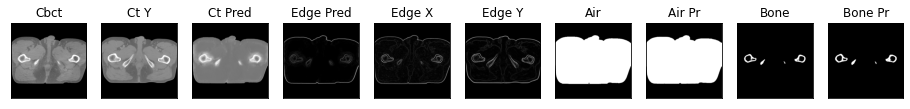

112it [00:43,  2.56it/s]

ssim score = 0.7815460562705994
psnr score = 20.770828247070312
snr score = 12.732673645019531
mae error = 0.05025261640548706
air dice score = 0.9956353396691332
bone dice score = 0.9293100525524782
contour dice score = 0.23903311789035797


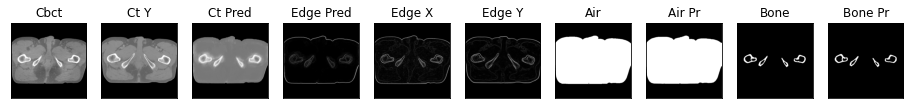

113it [00:43,  2.60it/s]

ssim score = 0.7727676033973694
psnr score = 20.696134567260742
snr score = 12.688217163085938
mae error = 0.05075953155755997
air dice score = 0.995540834718291
bone dice score = 0.9092086098088815
contour dice score = 0.22392776608467102


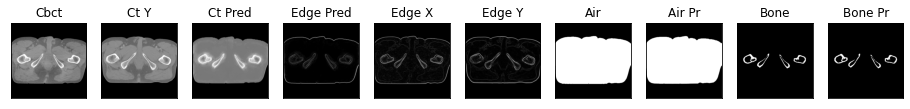

114it [00:44,  2.63it/s]

ssim score = 0.7670482993125916
psnr score = 20.6234130859375
snr score = 12.649909019470215
mae error = 0.05109695717692375
air dice score = 0.995396276176753
bone dice score = 0.9201497192776021
contour dice score = 0.21961139142513275


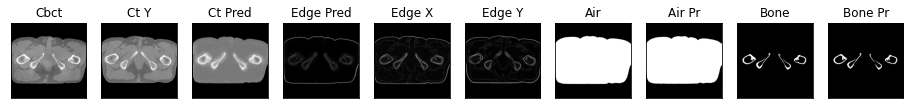

115it [00:44,  2.66it/s]

ssim score = 0.7603052258491516
psnr score = 20.411334991455078
snr score = 12.45814323425293
mae error = 0.05233683064579964
air dice score = 0.9950818528509005
bone dice score = 0.9088343211980126
contour dice score = 0.23031939566135406


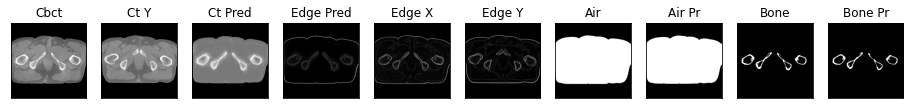

116it [00:44,  2.67it/s]

ssim score = 0.7623398900032043
psnr score = 20.534404754638672
snr score = 12.620287895202637
mae error = 0.051929228007793427
air dice score = 0.9947298160078967
bone dice score = 0.9082504552471179
contour dice score = 0.2505592703819275


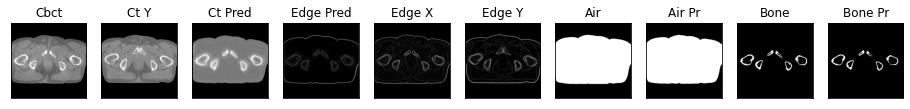

117it [00:45,  2.69it/s]

ssim score = 0.7636054158210754
psnr score = 20.60601043701172
snr score = 12.740569114685059
mae error = 0.05201556533575058
air dice score = 0.9943710031220655
bone dice score = 0.9062841530067447
contour dice score = 0.2363162487745285


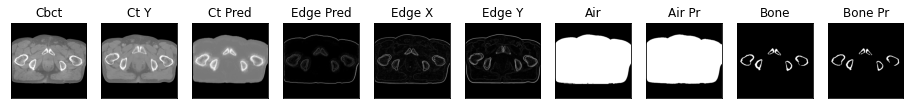

118it [00:45,  2.70it/s]

ssim score = 0.7513587474822998
psnr score = 20.417236328125
snr score = 12.574407577514648
mae error = 0.053303178399801254
air dice score = 0.9941867211250643
bone dice score = 0.9003309066856343
contour dice score = 0.2330923080444336


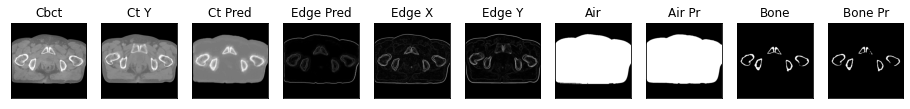

119it [00:46,  2.30it/s]

ssim score = 0.7361708283424377
psnr score = 20.304353713989258
snr score = 12.504305839538574
mae error = 0.05414619296789169
air dice score = 0.994313114583216
bone dice score = 0.8819626987122048
contour dice score = 0.22827938199043274


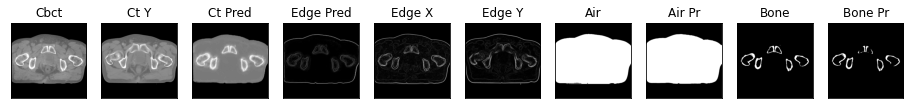

120it [00:46,  2.41it/s]

ssim score = 0.7405858635902405
psnr score = 20.425060272216797
snr score = 12.683348655700684
mae error = 0.05314748361706734
air dice score = 0.9941466455776613
bone dice score = 0.869575307497452
contour dice score = 0.2243415117263794


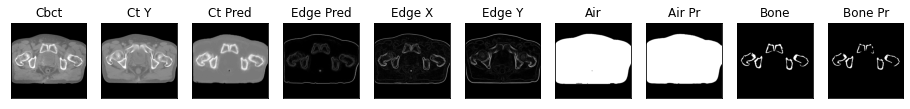

121it [00:46,  2.49it/s]

ssim score = 0.7364491820335388
psnr score = 20.420997619628906
snr score = 12.603914260864258
mae error = 0.05319150909781456
air dice score = 0.994433580793838
bone dice score = 0.8221759614350588
contour dice score = 0.21177545189857483


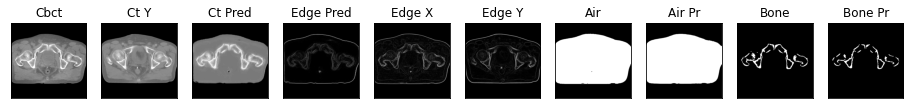

122it [00:47,  2.55it/s]

ssim score = 0.7413239479064941
psnr score = 20.466960906982422
snr score = 12.542662620544434
mae error = 0.05268002673983574
air dice score = 0.9942840003922212
bone dice score = 0.7939885914897543
contour dice score = 0.21937842667102814


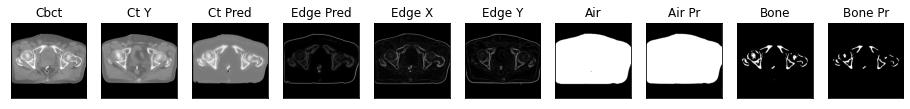

123it [00:47,  2.60it/s]

ssim score = 0.7564402222633362
psnr score = 20.822750091552734
snr score = 12.775358200073242
mae error = 0.05027753859758377
air dice score = 0.9947234730400677
bone dice score = 0.7651481645315662
contour dice score = 0.224977046251297


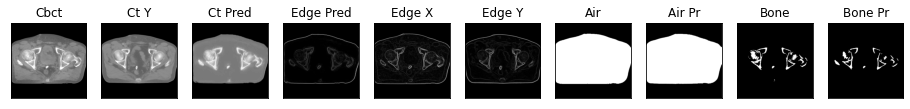

124it [00:48,  2.63it/s]

ssim score = 0.764288067817688
psnr score = 20.960390090942383
snr score = 12.800570487976074
mae error = 0.049012184143066406
air dice score = 0.9951980931222836
bone dice score = 0.8266785634639005
contour dice score = 0.22641509771347046


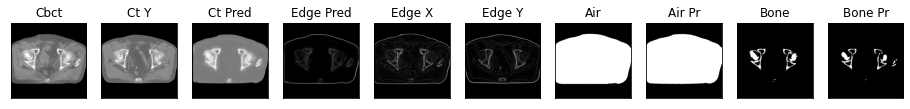

125it [00:48,  2.66it/s]

ssim score = 0.7662135362625122
psnr score = 21.0783748626709
snr score = 12.867908477783203
mae error = 0.048166424036026
air dice score = 0.9953663699365005
bone dice score = 0.8738225629805714
contour dice score = 0.2212962955236435


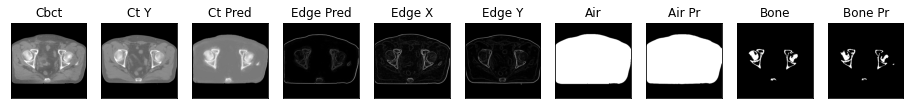

126it [00:48,  2.67it/s]

ssim score = 0.7651942372322083
psnr score = 20.848735809326172
snr score = 12.670426368713379
mae error = 0.04962186515331268
air dice score = 0.9955657972836169
bone dice score = 0.8900114810575198
contour dice score = 0.2114047259092331


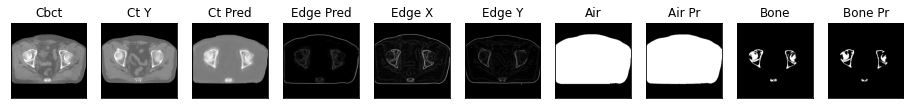

127it [00:49,  2.67it/s]

ssim score = 0.7635942697525024
psnr score = 20.64933967590332
snr score = 12.48450756072998
mae error = 0.05075029283761978
air dice score = 0.995847229442036
bone dice score = 0.8948780487817697
contour dice score = 0.17833800613880157


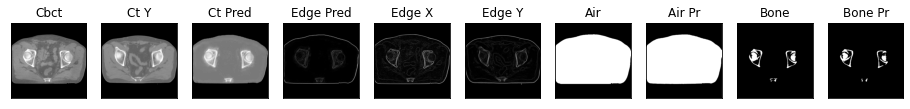

128it [00:49,  2.69it/s]

ssim score = 0.7602859139442444
psnr score = 20.550596237182617
snr score = 12.244271278381348
mae error = 0.05109529569745064
air dice score = 0.9955976614777796
bone dice score = 0.8916408668744069
contour dice score = 0.16173014044761658


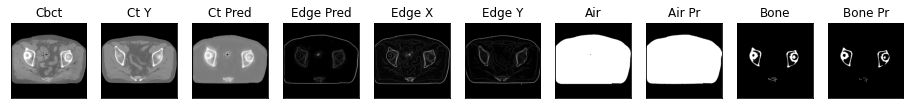

129it [00:50,  2.30it/s]

ssim score = 0.7704832553863525
psnr score = 20.710647583007812
snr score = 12.345014572143555
mae error = 0.049287099391222
air dice score = 0.995786516853935
bone dice score = 0.9201605092027099
contour dice score = 0.15901561081409454


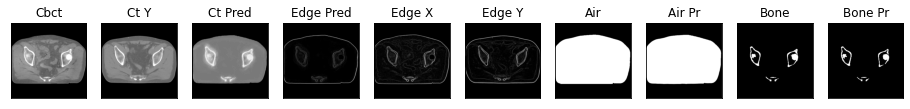

130it [00:50,  2.41it/s]

ssim score = 0.7723336815834045
psnr score = 20.915002822875977
snr score = 12.575016021728516
mae error = 0.047704584896564484
air dice score = 0.995843339559432
bone dice score = 0.8884601894091817
contour dice score = 0.15428301692008972


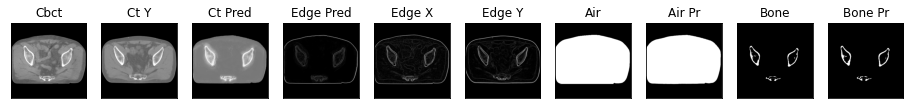

131it [00:50,  2.49it/s]

ssim score = 0.7662092447280884
psnr score = 20.674480438232422
snr score = 12.407310485839844
mae error = 0.04905392974615097
air dice score = 0.995864567567248
bone dice score = 0.915507295556235
contour dice score = 0.1401515156030655


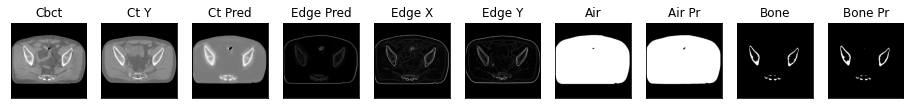

132it [00:51,  2.55it/s]

ssim score = 0.7554388642311096
psnr score = 20.21036148071289
snr score = 12.072420120239258
mae error = 0.051825907081365585
air dice score = 0.996127934019039
bone dice score = 0.918275418276733
contour dice score = 0.16213639080524445


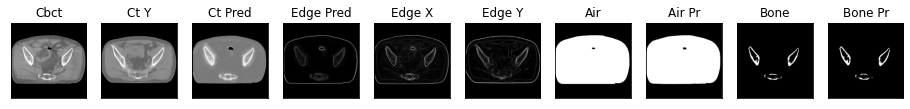

133it [00:51,  2.60it/s]

ssim score = 0.7451519966125488
psnr score = 19.973007202148438
snr score = 11.869025230407715
mae error = 0.05320598930120468
air dice score = 0.995954443781241
bone dice score = 0.9160120845934138
contour dice score = 0.17002882063388824


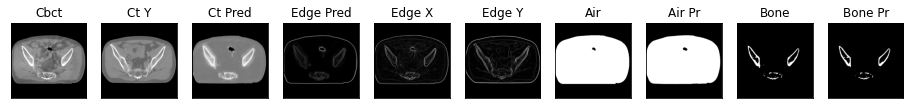

134it [00:52,  2.63it/s]

ssim score = 0.7418594360351562
psnr score = 20.302717208862305
snr score = 12.168943405151367
mae error = 0.05220069736242294
air dice score = 0.9959250795032732
bone dice score = 0.8779674066485568
contour dice score = 0.15703275799751282


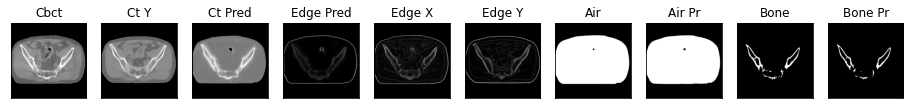

135it [00:52,  2.65it/s]

ssim score = 0.743058443069458
psnr score = 20.649005889892578
snr score = 12.45185661315918
mae error = 0.04974102973937988
air dice score = 0.9961667697757098
bone dice score = 0.8790344453501623
contour dice score = 0.1750483512878418


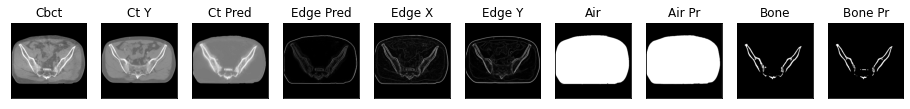

136it [00:52,  2.67it/s]

ssim score = 0.8199449777603149
psnr score = 22.391700744628906
snr score = 13.869091033935547
mae error = 0.0356316901743412
air dice score = 0.9963593310640844
bone dice score = 0.8649741063551222
contour dice score = 0.5390781760215759


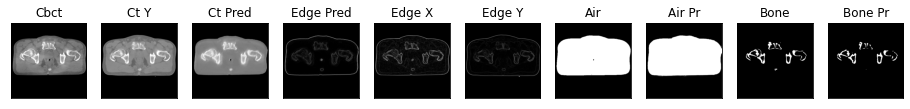

137it [00:53,  2.68it/s]

ssim score = 0.8207147121429443
psnr score = 22.29220962524414
snr score = 13.809613227844238
mae error = 0.035790879279375076
air dice score = 0.9963662790697702
bone dice score = 0.8623274161753803
contour dice score = 0.548110842704773


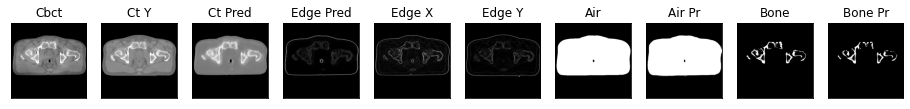

138it [00:53,  2.70it/s]

ssim score = 0.8217414617538452
psnr score = 22.430831909179688
snr score = 13.956022262573242
mae error = 0.035275351256132126
air dice score = 0.9963944982714391
bone dice score = 0.838692023534838
contour dice score = 0.53340083360672


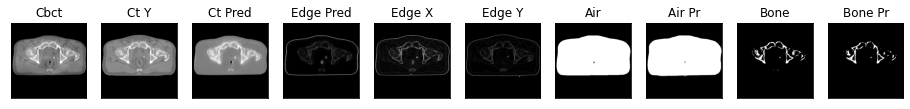

139it [00:54,  2.31it/s]

ssim score = 0.8237617015838623
psnr score = 22.419727325439453
snr score = 13.88649845123291
mae error = 0.03471792861819267
air dice score = 0.9962054136099193
bone dice score = 0.8369954011262519
contour dice score = 0.546653151512146


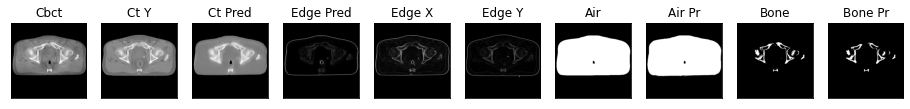

140it [00:54,  2.42it/s]

ssim score = 0.8277189135551453
psnr score = 22.489028930664062
snr score = 13.80017375946045
mae error = 0.034384243190288544
air dice score = 0.9958763040349613
bone dice score = 0.8498220640590772
contour dice score = 0.5590631365776062


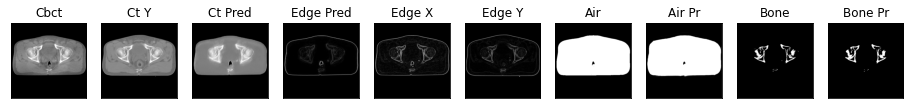

141it [00:54,  2.51it/s]

ssim score = 0.8306325674057007
psnr score = 22.601320266723633
snr score = 13.891664505004883
mae error = 0.033973000943660736
air dice score = 0.9957754166635544
bone dice score = 0.8824815523383099
contour dice score = 0.497700572013855


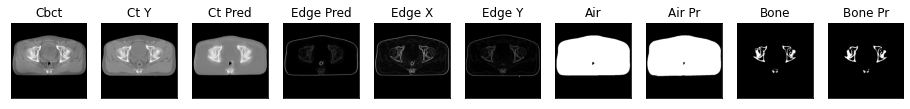

142it [00:55,  2.56it/s]

ssim score = 0.832629382610321
psnr score = 22.643836975097656
snr score = 13.91855239868164
mae error = 0.03367900475859642
air dice score = 0.9959573079721317
bone dice score = 0.8865838678874494
contour dice score = 0.5558974146842957


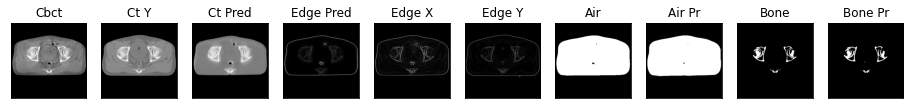

143it [00:55,  2.61it/s]

ssim score = 0.8263830542564392
psnr score = 22.147016525268555
snr score = 13.431095123291016
mae error = 0.03484909236431122
air dice score = 0.9957954699579579
bone dice score = 0.8921242373836367
contour dice score = 0.5378670692443848


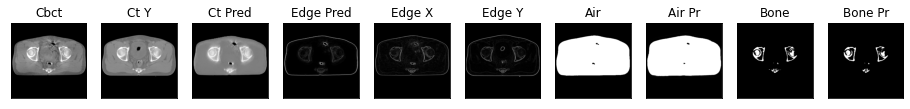

144it [00:55,  2.65it/s]

ssim score = 0.8243458271026611
psnr score = 22.237340927124023
snr score = 13.57719898223877
mae error = 0.035245902836322784
air dice score = 0.9956847775246347
bone dice score = 0.9057127010551066
contour dice score = 0.5758513808250427


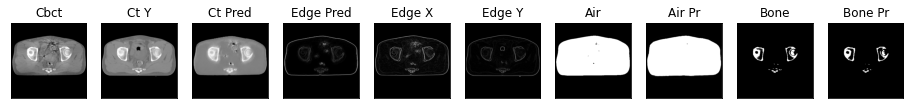

145it [00:56,  2.66it/s]

ssim score = 0.8236240744590759
psnr score = 21.75495147705078
snr score = 13.072880744934082
mae error = 0.036642998456954956
air dice score = 0.9951803576841504
bone dice score = 0.9094233473993049
contour dice score = 0.5402597188949585


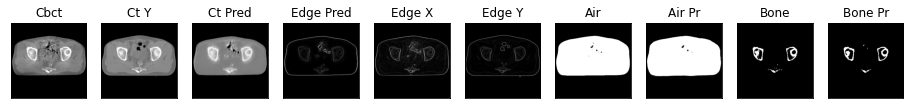

146it [00:56,  2.68it/s]

ssim score = 0.8246119618415833
psnr score = 21.317941665649414
snr score = 12.56509780883789
mae error = 0.03699691593647003
air dice score = 0.9952389644367412
bone dice score = 0.8974319544841237
contour dice score = 0.580510675907135


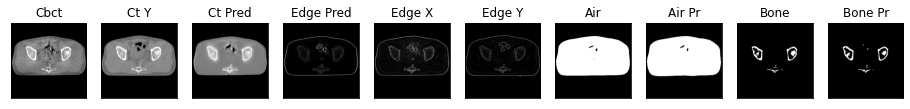

147it [00:56,  2.69it/s]

ssim score = 0.8242784142494202
psnr score = 21.705228805541992
snr score = 12.908492088317871
mae error = 0.035714905709028244
air dice score = 0.9956098637307822
bone dice score = 0.9044669057726693
contour dice score = 0.5961236357688904


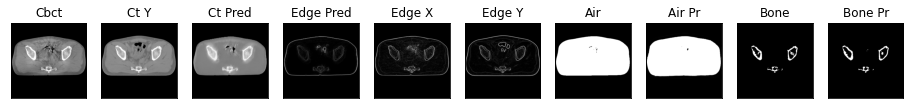

148it [00:57,  2.71it/s]

ssim score = 0.8265708088874817
psnr score = 21.99974250793457
snr score = 13.201908111572266
mae error = 0.034326884895563126
air dice score = 0.9954480188189324
bone dice score = 0.9116382741615724
contour dice score = 0.5724790096282959


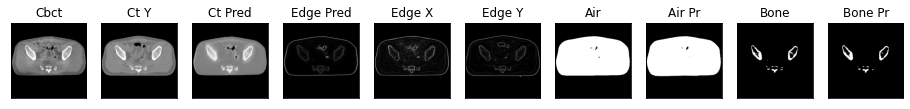

149it [00:57,  2.31it/s]

ssim score = 0.8197066783905029
psnr score = 21.958036422729492
snr score = 13.17355728149414
mae error = 0.03452248126268387
air dice score = 0.9948366208637384
bone dice score = 0.9191358024703837
contour dice score = 0.5334034562110901


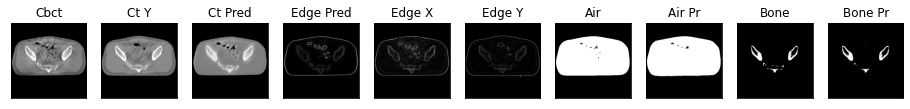

150it [00:58,  2.42it/s]

ssim score = 0.8184481263160706
psnr score = 21.935701370239258
snr score = 13.206428527832031
mae error = 0.03481585532426834
air dice score = 0.9946365822082527
bone dice score = 0.9042227254575167
contour dice score = 0.5443974733352661


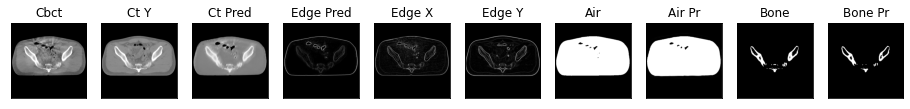

151it [00:58,  2.50it/s]

ssim score = 0.8201965093612671
psnr score = 21.52405548095703
snr score = 12.814149856567383
mae error = 0.035889774560928345
air dice score = 0.9944791481673131
bone dice score = 0.9001641137869234
contour dice score = 0.5547909140586853


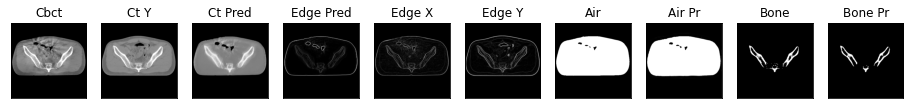

152it [00:59,  2.56it/s]

ssim score = 0.8224461674690247
psnr score = 21.74979019165039
snr score = 12.985148429870605
mae error = 0.035101115703582764
air dice score = 0.9947309546769568
bone dice score = 0.8883955002976851
contour dice score = 0.5283819437026978


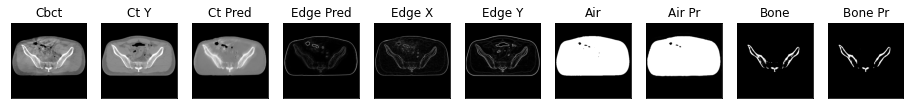

153it [00:59,  2.59it/s]

ssim score = 0.8222304582595825
psnr score = 21.998855590820312
snr score = 13.197860717773438
mae error = 0.03443877771496773
air dice score = 0.9952880025295211
bone dice score = 0.8744855967096636
contour dice score = 0.5455514192581177


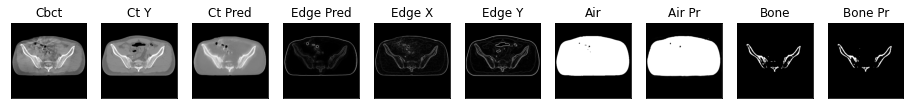

154it [00:59,  2.63it/s]

ssim score = 0.8279299736022949
psnr score = 22.165882110595703
snr score = 13.36495590209961
mae error = 0.033358074724674225
air dice score = 0.9949304382045919
bone dice score = 0.8615014050600629
contour dice score = 0.5595301389694214


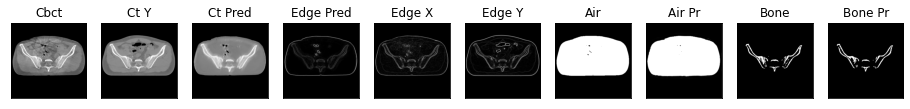

155it [01:00,  2.65it/s]

ssim score = 0.8288993835449219
psnr score = 22.32663917541504
snr score = 13.524292945861816
mae error = 0.03262878954410553
air dice score = 0.9949920398163786
bone dice score = 0.854655056934298
contour dice score = 0.5351961255073547


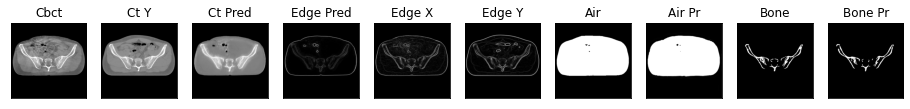

156it [01:00,  2.68it/s]

ssim score = 0.8193448781967163
psnr score = 21.795150756835938
snr score = 12.997845649719238
mae error = 0.034210436046123505
air dice score = 0.9945629833011498
bone dice score = 0.846888646290299
contour dice score = 0.528363049030304


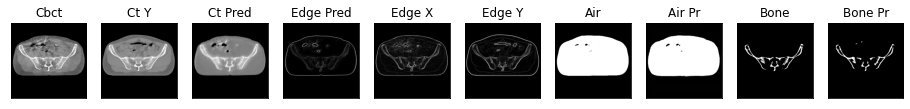

157it [01:00,  2.69it/s]

ssim score = 0.8166627883911133
psnr score = 21.470792770385742
snr score = 12.65621280670166
mae error = 0.03456741198897362
air dice score = 0.993751947647247
bone dice score = 0.8455619675756312
contour dice score = 0.5405111312866211


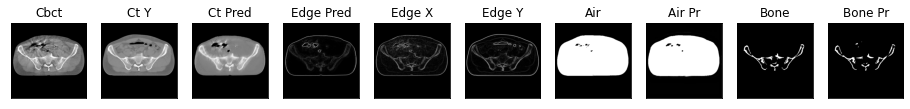

158it [01:01,  2.70it/s]

ssim score = 0.8121187686920166
psnr score = 21.164840698242188
snr score = 12.331639289855957
mae error = 0.03548793867230415
air dice score = 0.9937897914809127
bone dice score = 0.8141283910849566
contour dice score = 0.5005476474761963


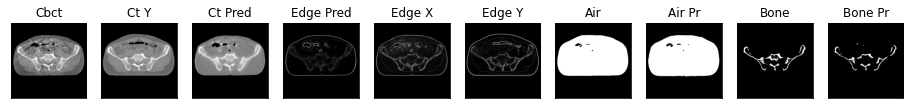

159it [01:01,  2.31it/s]

ssim score = 0.7999728918075562
psnr score = 20.76974105834961
snr score = 11.89059829711914
mae error = 0.03725508600473404
air dice score = 0.9933052357294834
bone dice score = 0.8048173844769627
contour dice score = 0.4782369136810303


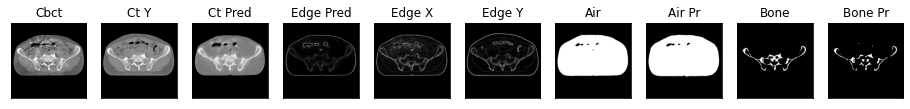

160it [01:02,  2.41it/s]

ssim score = 0.7998681664466858
psnr score = 20.779600143432617
snr score = 11.846660614013672
mae error = 0.03717316314578056
air dice score = 0.993183555425974
bone dice score = 0.8312444613263547
contour dice score = 0.4969562888145447


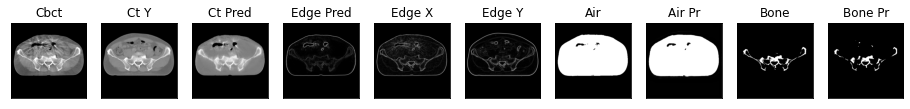

161it [01:02,  2.50it/s]

ssim score = 0.7945205569267273
psnr score = 20.485084533691406
snr score = 11.58260726928711
mae error = 0.03858903795480728
air dice score = 0.9931489509825693
bone dice score = 0.8393690851755284
contour dice score = 0.47078463435173035


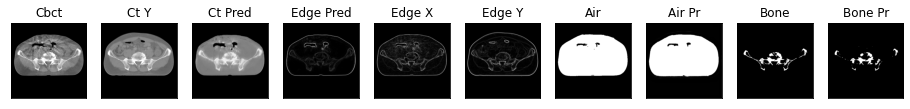

162it [01:02,  2.55it/s]

ssim score = 0.7887555360794067
psnr score = 20.2669677734375
snr score = 11.309266090393066
mae error = 0.039471257477998734
air dice score = 0.9929512135171835
bone dice score = 0.8467153284691162
contour dice score = 0.45863407850265503


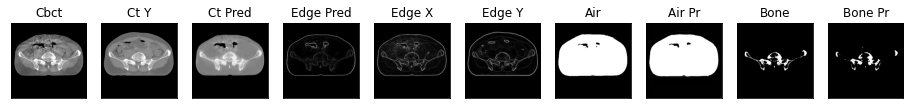

163it [01:03,  2.60it/s]

ssim score = 0.7991330027580261
psnr score = 20.909072875976562
snr score = 11.803837776184082
mae error = 0.03673087805509567
air dice score = 0.993465816614139
bone dice score = 0.8719295941170113
contour dice score = 0.46901172399520874


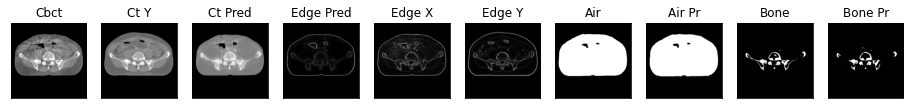

164it [01:03,  2.64it/s]

ssim score = 0.842424750328064
psnr score = 23.93486213684082
snr score = 14.315775871276855
mae error = 0.0322098508477211
air dice score = 0.9957500000000031
bone dice score = 0.9045558666351602
contour dice score = 0.6036821603775024


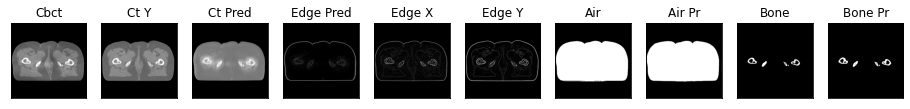

165it [01:04,  2.66it/s]

ssim score = 0.8406333327293396
psnr score = 24.046489715576172
snr score = 14.548412322998047
mae error = 0.03194689005613327
air dice score = 0.9960228103523936
bone dice score = 0.9083476764219375
contour dice score = 0.5767900943756104


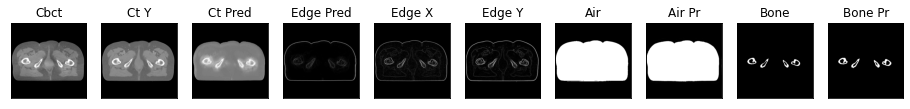

166it [01:04,  2.67it/s]

ssim score = 0.8365975618362427
psnr score = 24.039098739624023
snr score = 14.623941421508789
mae error = 0.03204004839062691
air dice score = 0.9961710877162419
bone dice score = 0.9018700597666884
contour dice score = 0.5460751056671143


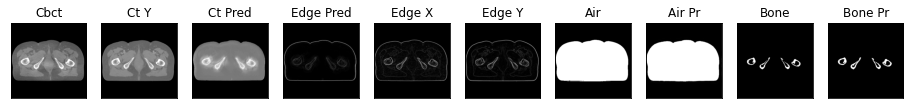

167it [01:04,  2.69it/s]

ssim score = 0.8332724571228027
psnr score = 24.064252853393555
snr score = 14.712539672851562
mae error = 0.031791653484106064
air dice score = 0.9963041984594827
bone dice score = 0.9172932330841874
contour dice score = 0.5317073464393616


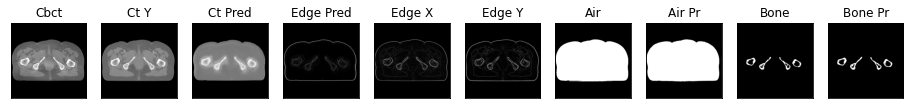

168it [01:05,  2.70it/s]

ssim score = 0.8311812877655029
psnr score = 23.994155883789062
snr score = 14.670902252197266
mae error = 0.03158775344491005
air dice score = 0.996098960924715
bone dice score = 0.9321126273979597
contour dice score = 0.49459195137023926


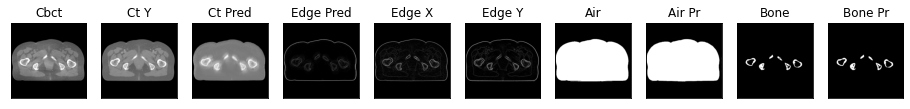

169it [01:05,  2.31it/s]

ssim score = 0.8307383060455322
psnr score = 23.864782333374023
snr score = 14.564484596252441
mae error = 0.032167013734579086
air dice score = 0.9959742351046728
bone dice score = 0.92448430493409
contour dice score = 0.5328786969184875


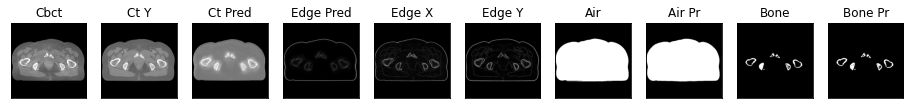

170it [01:06,  2.42it/s]

ssim score = 0.8277487754821777
psnr score = 23.80495834350586
snr score = 14.535988807678223
mae error = 0.03230619803071022
air dice score = 0.9959828409922411
bone dice score = 0.9164753664150367
contour dice score = 0.5169082283973694


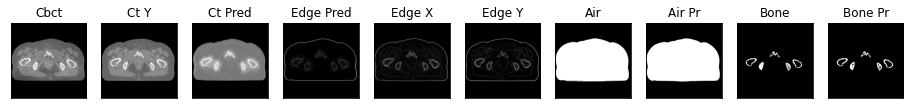

171it [01:06,  2.49it/s]

ssim score = 0.8260586857795715
psnr score = 23.775039672851562
snr score = 14.554431915283203
mae error = 0.03193913400173187
air dice score = 0.9962954735989823
bone dice score = 0.9157041889343958
contour dice score = 0.49248120188713074


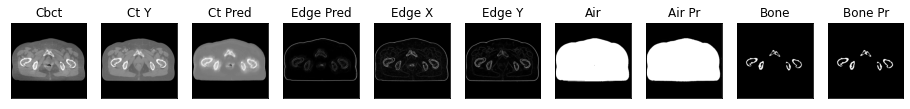

172it [01:06,  2.54it/s]

ssim score = 0.8264884948730469
psnr score = 23.5529727935791
snr score = 14.375109672546387
mae error = 0.03164171054959297
air dice score = 0.9961422630144872
bone dice score = 0.9095330739314278
contour dice score = 0.4858377277851105


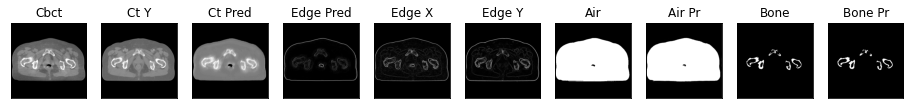

173it [01:07,  2.59it/s]

ssim score = 0.8253777623176575
psnr score = 23.492429733276367
snr score = 14.40226936340332
mae error = 0.0313713438808918
air dice score = 0.9957897303849522
bone dice score = 0.8988120795778043
contour dice score = 0.4684431850910187


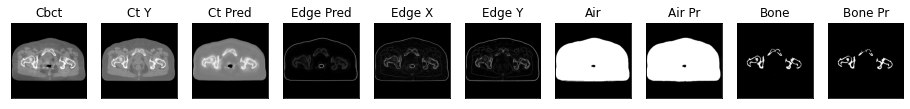

174it [01:07,  2.63it/s]

ssim score = 0.8294546604156494
psnr score = 24.151912689208984
snr score = 15.175025939941406
mae error = 0.03031814470887184
air dice score = 0.995212033423007
bone dice score = 0.8888888888902606
contour dice score = 0.44464945793151855


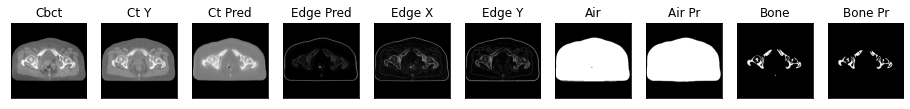

175it [01:07,  2.66it/s]

ssim score = 0.8309425711631775
psnr score = 23.482608795166016
snr score = 14.377172470092773
mae error = 0.0321371890604496
air dice score = 0.9949988568815765
bone dice score = 0.8725382070289501
contour dice score = 0.5186894536018372


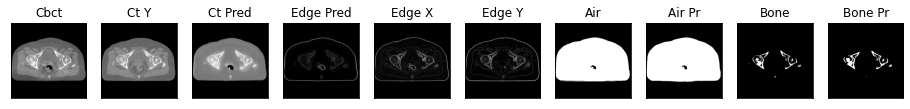

176it [01:08,  2.68it/s]

ssim score = 0.8315995335578918
psnr score = 23.46139907836914
snr score = 14.246536254882812
mae error = 0.032522279769182205
air dice score = 0.9950098161699126
bone dice score = 0.8480881846391993
contour dice score = 0.5527544617652893


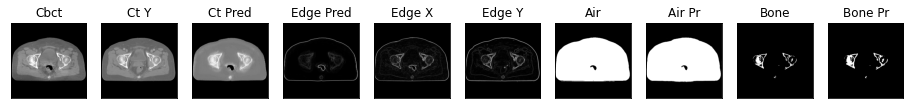

177it [01:08,  2.69it/s]

ssim score = 0.8359349966049194
psnr score = 23.552396774291992
snr score = 14.310408592224121
mae error = 0.03253276273608208
air dice score = 0.9950834952008971
bone dice score = 0.8962098192884022
contour dice score = 0.5710357427597046


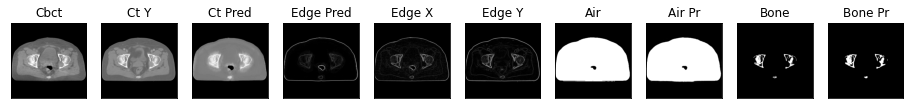

178it [01:09,  2.70it/s]

ssim score = 0.8413958549499512
psnr score = 24.0872745513916
snr score = 14.83728313446045
mae error = 0.03186148777604103
air dice score = 0.9956516214651807
bone dice score = 0.9117321964327849
contour dice score = 0.5307262539863586


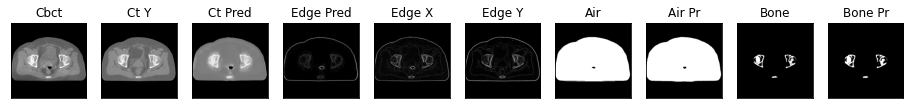

179it [01:09,  2.29it/s]

ssim score = 0.8416744470596313
psnr score = 24.46468162536621
snr score = 15.248917579650879
mae error = 0.031302232295274734
air dice score = 0.9959482438891288
bone dice score = 0.9266789895266994
contour dice score = 0.5394737124443054


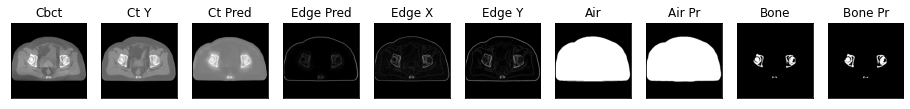

180it [01:10,  2.41it/s]

ssim score = 0.8364123106002808
psnr score = 24.086484909057617
snr score = 14.922210693359375
mae error = 0.03231256827712059
air dice score = 0.9965116602273699
bone dice score = 0.9419172044712433
contour dice score = 0.5093705058097839


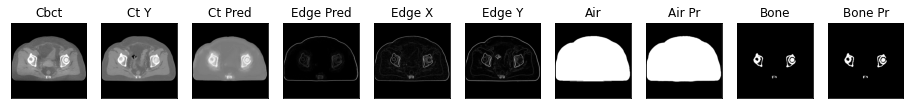

181it [01:10,  2.49it/s]

ssim score = 0.8233509063720703
psnr score = 23.31801986694336
snr score = 14.191305160522461
mae error = 0.034669797867536545
air dice score = 0.9965604472107938
bone dice score = 0.9332657543515245
contour dice score = 0.4908212423324585


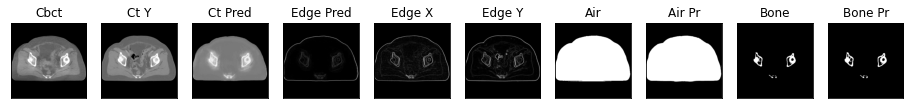

182it [01:10,  2.56it/s]

ssim score = 0.8077928423881531
psnr score = 22.186553955078125
snr score = 12.98740291595459
mae error = 0.0382315069437027
air dice score = 0.9961762351991599
bone dice score = 0.8912065439695049
contour dice score = 0.4934178590774536


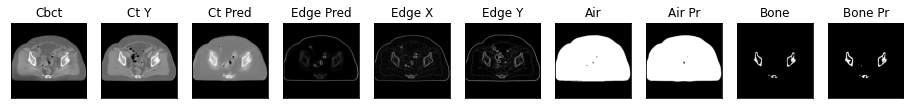

183it [01:11,  2.60it/s]

ssim score = 0.8043922185897827
psnr score = 21.806114196777344
snr score = 12.588970184326172
mae error = 0.03930419683456421
air dice score = 0.99648335203891
bone dice score = 0.9094300518153486
contour dice score = 0.48520711064338684


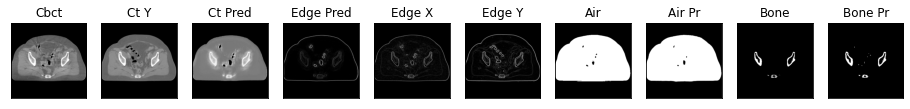

184it [01:11,  2.64it/s]

ssim score = 0.8065865635871887
psnr score = 22.354137420654297
snr score = 13.201908111572266
mae error = 0.037876032292842865
air dice score = 0.9967422325130602
bone dice score = 0.9104145601635912
contour dice score = 0.46617284417152405


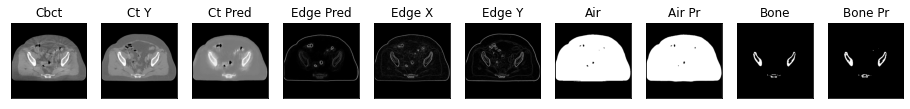

185it [01:11,  2.66it/s]

ssim score = 0.8094924688339233
psnr score = 22.549053192138672
snr score = 13.45191764831543
mae error = 0.037049513310194016
air dice score = 0.9964490722199997
bone dice score = 0.9325418240702906
contour dice score = 0.4524165391921997


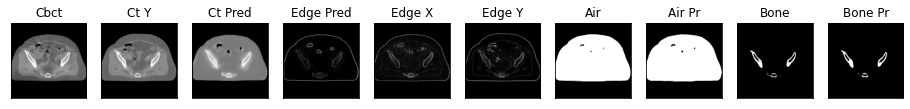

186it [01:12,  2.68it/s]

ssim score = 0.8052541613578796
psnr score = 22.129432678222656
snr score = 13.096725463867188
mae error = 0.03767617419362068
air dice score = 0.9966883696334754
bone dice score = 0.9322916666677039
contour dice score = 0.40137389302253723


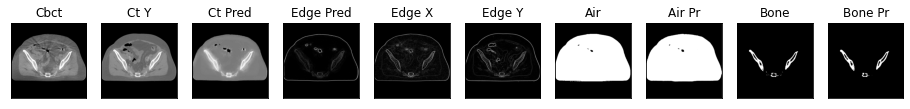

187it [01:12,  2.70it/s]

ssim score = 0.8012061715126038
psnr score = 21.958181381225586
snr score = 12.998334884643555
mae error = 0.03794986382126808
air dice score = 0.9963787131311035
bone dice score = 0.9042145593883324
contour dice score = 0.37395164370536804


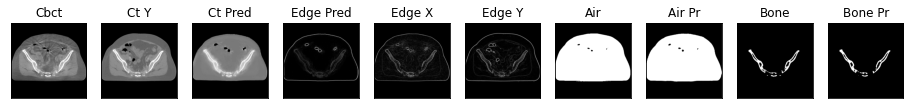

188it [01:12,  2.70it/s]

ssim score = 0.7978484630584717
psnr score = 21.98377799987793
snr score = 13.01964282989502
mae error = 0.03804750740528107
air dice score = 0.9959522600965757
bone dice score = 0.8955350815039612
contour dice score = 0.3820224702358246


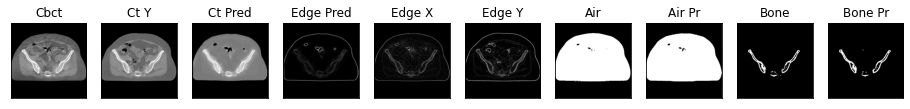

189it [01:13,  2.31it/s]

ssim score = 0.7949069142341614
psnr score = 22.112560272216797
snr score = 13.12624740600586
mae error = 0.03781593590974808
air dice score = 0.9971316415389889
bone dice score = 0.8950156186351349
contour dice score = 0.3613404631614685


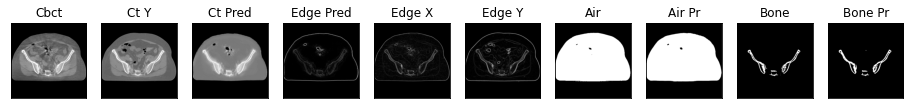

190it [01:13,  2.42it/s]

ssim score = 0.8013142347335815
psnr score = 22.667484283447266
snr score = 13.692806243896484
mae error = 0.036258988082408905
air dice score = 0.9970282412940271
bone dice score = 0.8917452156542167
contour dice score = 0.32674700021743774


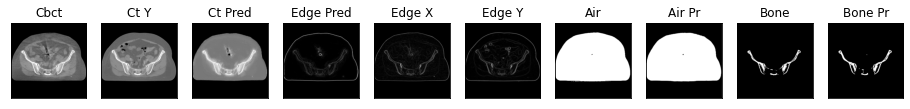

191it [01:14,  2.57it/s]


In [42]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [43]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [44]:
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [45]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:09, 19.69it/s]


(0.8230725024383105,
 22.643607194511056,
 13.64787914615651,
 0.03516232312037683,
 0.9882261998628324,
 0.882931712359136,
 0.4424239920149923,
 0.5,
 0.15968586387434555)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)